<font color=red><p style="font-size:32px;text-align:center"><b>Personalized Cancer Diagnosis</b></p></font>

**<font color=green><h2>Business Problem</h2></font>**

<p>Data: Memorial Sloan Kettering Cancer Center (MSKCC)</p>
<p>Download training_variants.zip and training_text.zip from Kaggle.</p> 

<h6>Context:</h6>
<p>Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462</p>

<h6>Problem statement:</h6>
<p>Classify the given genetic variations/mutations based on evidence from text-based clinical literature.</p>

**<font color=green><h2>Real-World/Business Objectives and Constraints</h2></font>**

* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

**<font color=green><h2>Data Overview</h2></font>**

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files are have a common column called ID
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

**<font color=blue>Reading Data: </font>**training_variants_file

In [1]:
import pandas as pd

#read_training_variants_file
data = pd.read_csv("D:/Applied_Ai/Case Studies/Cancer/training_variants")

In [2]:
print("NUMBER OF DATA POINTS -",data.shape[0])
print("NUMBER OF FEATURES -",data.shape[1])
print("FEATURES -",data.columns.values)

NUMBER OF DATA POINTS - 3321
NUMBER OF FEATURES - 4
FEATURES - ['ID' 'Gene' 'Variation' 'Class']


In [3]:
data.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


training_variants file is a comma separated file containing the description of the genetic mutations used for training.
<br>
    <ul>
        <li><b>ID : </b>The id of the row used to link the mutation to the clinical evidence.</li>
        <li><b>Gene : </b>The gene where this genetic mutation is located.</li>
        <li><b>Variation : </b>The amino_acid change for this mutations.</li>
        <li><b>Class : </b>1 to 9 class; This genetic mutation has been classified on.</li>
    </ul>

**<font color=blue>Reading Data: </font>**training_text_file

In [4]:
#read_training_variants_file
data_text = pd.read_csv("D:/Applied_Ai/Case Studies/Cancer/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [5]:
print("NUMBER OF DATA POINTS -",data_text.shape[0])
print("NUMBER OF FEATURES -",data_text.shape[1])
print("FEATURES -",data_text.columns.values)

NUMBER OF DATA POINTS - 3321
NUMBER OF FEATURES - 2
FEATURES - ['ID' 'TEXT']


In [6]:
data_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


**<font color=blue>Preprocessing Text Data</font>**

In [7]:
from nltk.corpus import stopwords
import nltk

import re
import time

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import log_loss
import math
from collections import Counter
from scipy.sparse import hstack

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

In [8]:
#loading_the_stop_words_from_nltk_library_
stop_words = set(stopwords.words('english'))

def txt_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        
        #replace_every_special_char_with_space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        
        #replace_multiple_spaces_with_single_space
        total_text = re.sub('\s+',' ', total_text)
        
        #converting_all_the_chars_into_lower_case
        total_text = total_text.lower()
        
        for word in total_text.split():
        #if_the_word_is_a_not_a_stop_word_then_retain_that_word_from_the_data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [9]:
#text_processing_stage_
start_time = time.clock()

for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        txt_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("THERE IS NO TEXT DESCRIPTION FOR ID :",index)

print("TIME TOOK FOR PREPROCESSING THE TEXT :",time.clock() - start_time, "SECONDS")

THERE IS NO TEXT DESCRIPTION FOR ID : 1109
THERE IS NO TEXT DESCRIPTION FOR ID : 1277
THERE IS NO TEXT DESCRIPTION FOR ID : 1407
THERE IS NO TEXT DESCRIPTION FOR ID : 1639
THERE IS NO TEXT DESCRIPTION FOR ID : 2755
TIME TOOK FOR PREPROCESSING THE TEXT : 24.563885600000003 SECONDS


In [10]:
#merging_both_gene_variations_and_text_data_based_on_ID

result = pd.merge(data, data_text, on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [11]:
#checking_null_values
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [12]:
#fill_null_space_>>>_add_combination_of_gene_and_variation_as_a_text_for_perticular_ids
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

In [13]:
#check_one_of_result
result[result['ID']==1407]

,ID,Gene,Variation,Class,TEXT
1407,1407,FGFR3,K508M,6,FGFR3 K508M


**<font color=blue>Train, Cross Validation and Test Split</font>**

In [14]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

#splitting_data_into_train_cv_and_test
#train_data_64_%
#cross_validation_data_16_%
#test_data_20_%

#train_data_+_cross_validation_data_>>>_80_%_and_test_data_20_%

#split_the_data_into_train_and_test_by_maintaining_same_distribution_of_output_varaible_'y_true'_[stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)

#split_the_train_data_into_train_and_cross_validation_by_maintaining_same_distribution_of_output_varaible_'y_train'_[stratify=y_train]
X_train, x_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [15]:
print("NUMBER OF DATA POINTS IN TRAIN DATA :", X_train.shape[0])
print("NUMBER OF DATA POINTS IN TEST DATA :", X_test.shape[0])
print("NUMBER OF DATA POINTS IN CROSS VALIDATION DATA :", x_cv.shape[0])

NUMBER OF DATA POINTS IN TRAIN DATA : 2124
NUMBER OF DATA POINTS IN TEST DATA : 665
NUMBER OF DATA POINTS IN CROSS VALIDATION DATA : 532


**<font color=green><h2>Exploratory Data Analysis</h2></font>**

**<font color=blue>Distribution of y_i's in Train, Test and Cross Validation Datasets</font>**

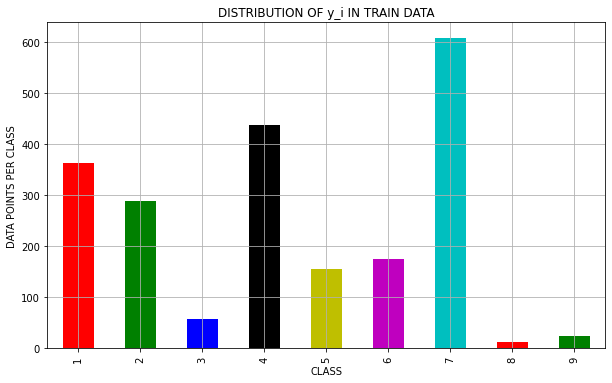

NUMBER OF DATA POINTS IN CLASS 7 : 609 ( 28.672 %)
NUMBER OF DATA POINTS IN CLASS 4 : 439 ( 20.669 %)
NUMBER OF DATA POINTS IN CLASS 1 : 363 ( 17.09 %)
NUMBER OF DATA POINTS IN CLASS 2 : 289 ( 13.606 %)
NUMBER OF DATA POINTS IN CLASS 6 : 176 ( 8.286 %)
NUMBER OF DATA POINTS IN CLASS 5 : 155 ( 7.298 %)
NUMBER OF DATA POINTS IN CLASS 3 : 57 ( 2.684 %)
NUMBER OF DATA POINTS IN CLASS 9 : 24 ( 1.13 %)
NUMBER OF DATA POINTS IN CLASS 8 : 12 ( 0.565 %)
----------------------------------------------------------------------------------------------------


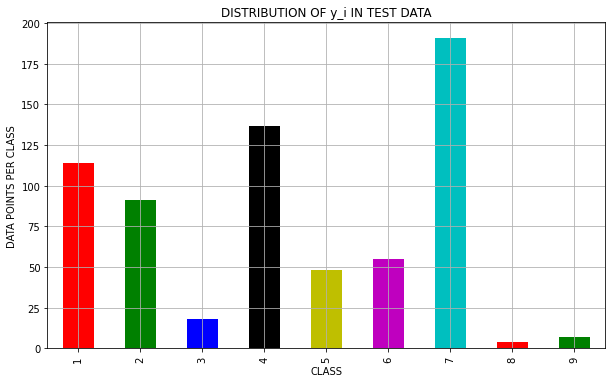

NUMBER OF DATA POINTS IN CLASS 7 : 191 ( 28.722 %)
NUMBER OF DATA POINTS IN CLASS 4 : 137 ( 20.602 %)
NUMBER OF DATA POINTS IN CLASS 1 : 114 ( 17.143 %)
NUMBER OF DATA POINTS IN CLASS 2 : 91 ( 13.684 %)
NUMBER OF DATA POINTS IN CLASS 6 : 55 ( 8.271 %)
NUMBER OF DATA POINTS IN CLASS 5 : 48 ( 7.218 %)
NUMBER OF DATA POINTS IN CLASS 3 : 18 ( 2.707 %)
NUMBER OF DATA POINTS IN CLASS 9 : 7 ( 1.053 %)
NUMBER OF DATA POINTS IN CLASS 8 : 4 ( 0.602 %)
----------------------------------------------------------------------------------------------------


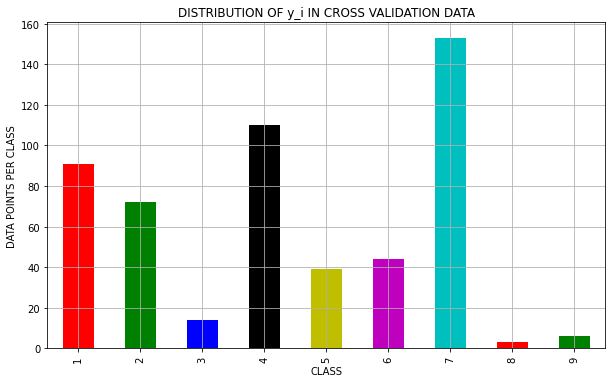

NUMBER OF DATA POINTS IN CLASS 7 : 153 ( 28.759 %)
NUMBER OF DATA POINTS IN CLASS 4 : 110 ( 20.677 %)
NUMBER OF DATA POINTS IN CLASS 1 : 91 ( 17.105 %)
NUMBER OF DATA POINTS IN CLASS 2 : 72 ( 13.534 %)
NUMBER OF DATA POINTS IN CLASS 6 : 44 ( 8.271 %)
NUMBER OF DATA POINTS IN CLASS 5 : 39 ( 7.331 %)
NUMBER OF DATA POINTS IN CLASS 3 : 14 ( 2.632 %)
NUMBER OF DATA POINTS IN CLASS 9 : 6 ( 1.128 %)
NUMBER OF DATA POINTS IN CLASS 8 : 3 ( 0.564 %)


In [16]:
#this_returns_a_dict_keys_as_class_labels_and_values_as_the_number_of_data_points_in_that_class
train_class_distribution = X_train['Class'].value_counts().sort_index()
test_class_distribution = X_test['Class'].value_counts().sort_index()
cv_class_distribution = x_cv['Class'].value_counts().sort_index()

#distribution_of y_i's_in_train_data
plt.figure(figsize=(10,6))
my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
train_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('CLASS')
plt.ylabel('DATA POINTS PER CLASS')
plt.title('DISTRIBUTION OF y_i IN TRAIN DATA')
plt.grid()
plt.show()

#ref:_argsort_https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
#-(train_class_distribution.values):_the_minus_sign_will_returns_in_decreasing_order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('NUMBER OF DATA POINTS IN CLASS', i+1, ':',train_class_distribution.values[i],'(',np.round((train_class_distribution.values[i]/X_train.shape[0]*100), 3),'%)')

print("-"*100)
#distribution_of y_i's_in_test_data
plt.figure(figsize=(10,6))
my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
test_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('CLASS')
plt.ylabel('DATA POINTS PER CLASS')
plt.title('DISTRIBUTION OF y_i IN TEST DATA')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('NUMBER OF DATA POINTS IN CLASS', i+1, ':',test_class_distribution.values[i],'(',np.round((test_class_distribution.values[i]/X_test.shape[0]*100), 3),'%)')

print("-"*100)
#distribution_of y_i's_in_cv_data
plt.figure(figsize=(10,6))
my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
cv_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('CLASS')
plt.ylabel('DATA POINTS PER CLASS')
plt.title('DISTRIBUTION OF y_i IN CROSS VALIDATION DATA')
plt.grid()
plt.show()

sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('NUMBER OF DATA POINTS IN CLASS', i+1, ':',cv_class_distribution.values[i],'(',np.round((cv_class_distribution.values[i]/x_cv.shape[0]*100), 3),'%)')

**<font color=green><h2>Prediction Using a 'Random' Model</h2></font>**
- In a 'Random' Model, we generate the 9 class probabilites randomly such that they sum to 1.

In [17]:
#this_function_plots_the_confusion_matrices_given_y_i_and_y_i_hat_
def plot_confusion_matrix(test_y, predict_y):

    C = confusion_matrix(test_y, predict_y) #9_x_9_matrix
    #each_cell_(i,j)_represents_number_of_points_of_class_i_are_predicted_class_j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid_each_element_of_the_confusion_matrix_with_the_sum_of_elements_in_that_column
    
    #C = [[1, 2],
    #    [3, 4]]
    #C.T = [[1, 3],
    #       [2, 4]]
    
    #C.sum(axis=1)_axis=1_corresonds_to_rows_and_axis=0_corresponds_to_columns_in_two_diamensional_array
    
    #C.sum(axix=1) = [[3, 7]]
    #((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    #((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                            [3/7, 4/7]]
    #sum_of_row_elements_=_1
    
    B =(C/C.sum(axis=0))
    #divid_each_element_of_the_confusion_matrix_with_the_sum_of_elements_in_that_row
    
    #(C/C.sum(axis=0)) = [[1/4, 2/6],
    #                     [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    
    #representing_C_in_heatmap_format
    print("-"*40, "Confusion Matrix", "-"*40)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    #representing_B_in_heatmap_format
    print("-"*40, "Precision Matrix (Columm Sum=1)", "-"*40)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    #representing_A_in_heatmap_format
    print("-"*40, "Recall Matrix (Row Sum=1)", "-"*40)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [18]:
#creating_random_model

#for_that_we_need_to_generate_9_numbers_and_the_sum_of_numbers_should_be_1
#one_solution_is_to_generate_9_numbers_and_divide_each_of_the_numbers_by_their_sum
#ref:https://stackoverflow.com/a/18662466/4084039

test_data_len = X_test.shape[0]
cv_data_len = x_cv.shape[0]

#cv_set_error_
#we_create_a_output_array_that_has_exactly_same_size_as_the_CV_data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    
print("Log Loss on Cross Validation Data using Random Model -",log_loss(y_cv,cv_predicted_y, eps=1e-15))

#test_set_error_
#we_create_a_output_array_that_has_exactly_same_size_as_the_test_data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    
print("Log Loss on Test Data using Random Model -",log_loss(y_test,test_predicted_y, eps=1e-15))

Log Loss on Cross Validation Data using Random Model - 2.4232723848945494
Log Loss on Test Data using Random Model - 2.5175397761793885


---------------------------------------- Confusion Matrix ----------------------------------------


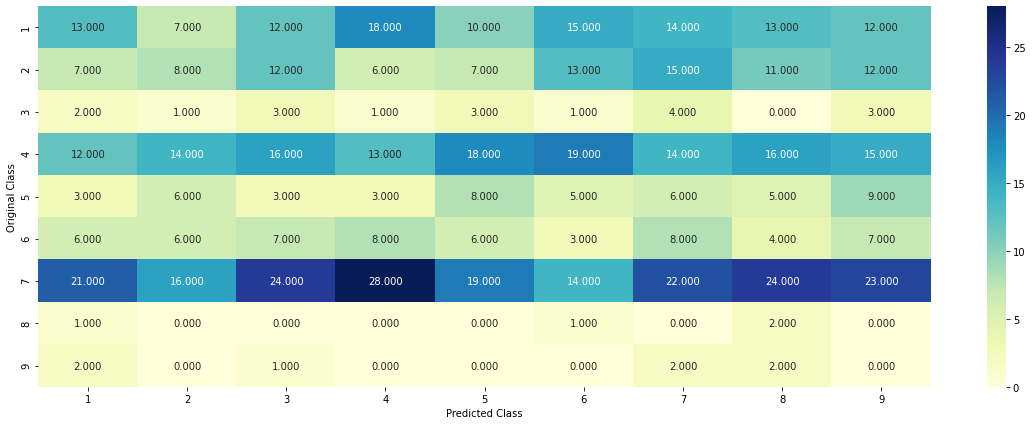

---------------------------------------- Precision Matrix (Columm Sum=1) ----------------------------------------


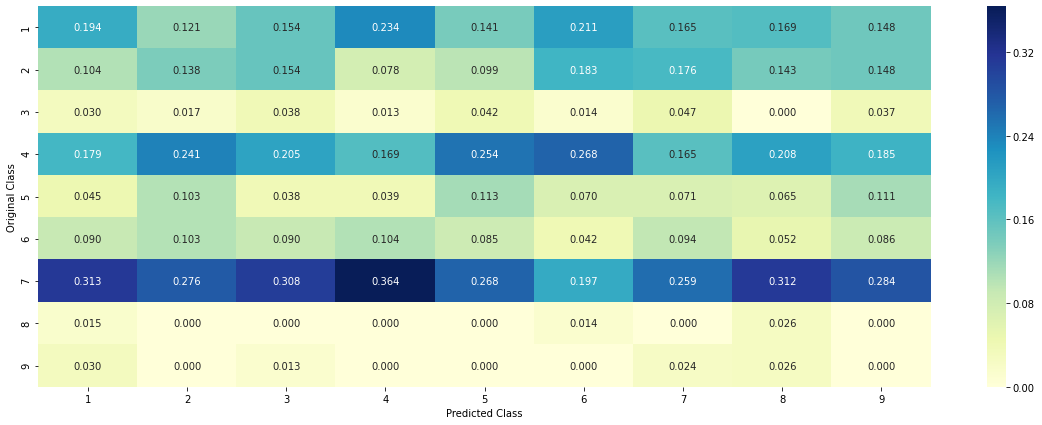

---------------------------------------- Recall Matrix (Row Sum=1) ----------------------------------------


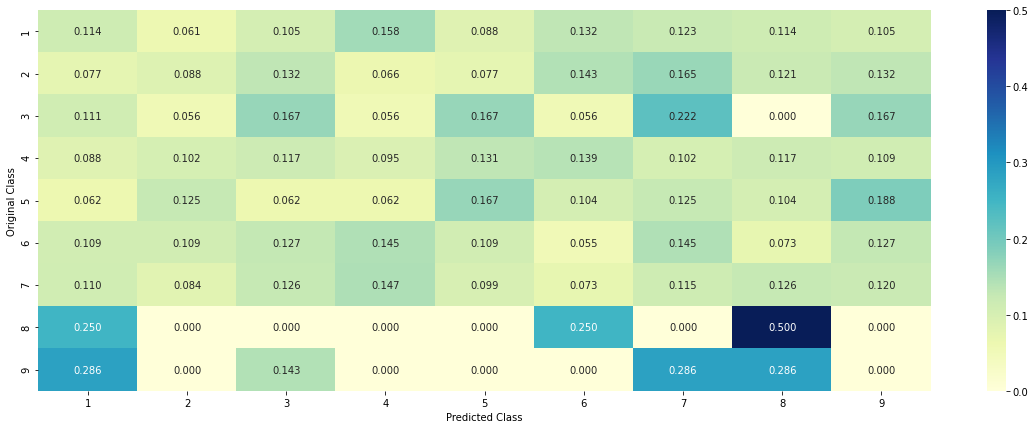

In [19]:
#plot_confusion_matrix_
predicted_y = np.argmax(test_predicted_y, axis=1)

plot_confusion_matrix(y_test, predicted_y+1)

In [ ]:
#precision_matrix
#Of all the points which predicted to be class 1 (y_i_hat = 1), 19.4% of points are actually belongs to class 1.
#Of all the points which predicted to be class 5 (y_i_hat = 5), 26.8% of points are actually belongs to class 7.

#recall_matrix
#Of all the points which are originally belongs to class 8 (y_i = 8), 50% of points were classified to class 6.
#Of all the points which are originally belongs to class 9 (y_i = 9), 28.6% of points were classified to class 1.

**<font color=green><h2>Univariate Analysis</h2></font>**

**Response Coding with Laplace Smoothing**

- alpha : used for laplace smoothing
- features: 'gene', 'variation'
- df: 'X_train', 'X_test', 'x_cv'

_**Algorithm**_
- Consider all unique values and the number of occurances of given feature in train data dataframe.
- Build a vector (1x9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha).
- gv_dict is like a look up table, for every gene it store a (1*9) representation of it.
- For a value of feature in df: if it is in train data: we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'.
- If it is not there is train: we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea' and return 'gv_fea'.

In [20]:
#this_get_gv_fea_dict_returns_gene_varaition_feature_dict_
def get_gv_fea_dict(alpha, feature, df):
    
    value_count = X_train[feature].value_counts() #value_count:_it_contains_a_dict_like
    
    gv_dict = dict() #gv_dict:_gene_varaition_feature_dict,_which_contains_the_probability_array_for_each_gene/variation
    
    #denominator_will_contain_the_number_of_time_that_particular_feature_occured_in_whole_data
    for i, denominator in value_count.items():
        
        #_vec_will_contain_(p(yi==1/Gi)_probability_of_gene/variation_belongs_to_perticular_class
        #_vec_is_9_diamensional_vector
        vec = []
        for k in range(1,10):
            cls_cnt = X_train.loc[(X_train['Class']==k) & (X_train[feature]==i)]

            #cls_cnt.shape[0](numerator)_will_contain_the_number_of_time_that_particular_feature_occured_in_whole_data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        #we_are_adding_the_gene/variation_to_the_dict_as_key_and_vec_as_value
        gv_dict[i]=vec
    return gv_dict

def get_gv_feature(alpha, feature, df): #get_gene_varaition_feature
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    
    #value_count is similar in get_gv_fea_dict
    value_count = X_train[feature].value_counts()
    
    #gv_fea: gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    
    #for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    #if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])

    return gv_fea

When we caculate the probability of a feature belongs to any particular class, we apply laplace smoothing;
<li>(numerator + 10\*alpha) / (denominator + 90\*alpha) </li>

**<font color=blue>Univariate Analysis on Gene Feature</font>**
- Gene is the **Categorical** variable (feature).

In [21]:
#to check how many categories are there;
unique_genes = X_train['Gene'].value_counts()
print('NUMBER OF UNIQUE GENES: ',unique_genes.shape[0])

#top 10 genes that occured most;
print(unique_genes.head(10))

NUMBER OF UNIQUE GENES:  244
BRCA1     165
TP53      104
EGFR       99
PTEN       85
BRCA2      80
KIT        64
BRAF       63
ERBB2      42
ALK        39
PDGFRA     36
Name: Gene, dtype: int64


In [22]:
print("There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows:")

There are 244 different categories of genes in the train data, and they are distibuted as follows:


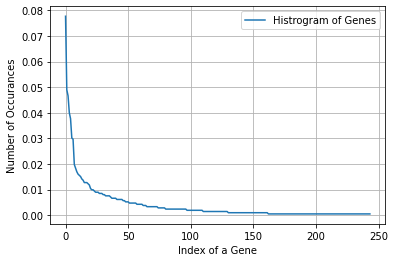

In [23]:
s = sum(unique_genes.values)
h = unique_genes.values/s

plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

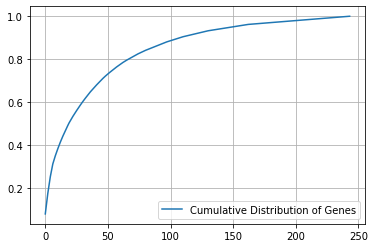

In [24]:
#cdf
c = np.cumsum(h)
plt.plot(c,label='Cumulative Distribution of Genes')
plt.grid()
plt.legend()
plt.show()

**<font color=blue>Featurizing Gene Feature</font>**

_There are two ways of featurize this variable:_
1. One Hot Encoding
2. Response Coding

We will choose the appropriate featurization based on the ML model we use. For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding is better for Random Forests.

In [25]:
#response_coding of the gene feature

alpha = 1 #alpha is used for laplace smoothing

#train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", X_train))

#test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", X_test))

#cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", x_cv))

In [26]:
print("Train Gene Feature is Converted using Respone Coding Method. The Shape of Gene Feature:", train_gene_feature_responseCoding.shape)

Train Gene Feature is Converted using Respone Coding Method. The Shape of Gene Feature: (2124, 9)


In [27]:
#one_hot encoding of gene feature

gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(X_train['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(X_test['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(x_cv['Gene'])

In [28]:
print("Train Gene Feature is Converted using One Hot Encoding Method. The Shape of Gene Feature:", train_gene_feature_onehotCoding.shape)

Train Gene Feature is Converted using One Hot Encoding Method. The Shape of Gene Feature: (2124, 243)


In [29]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'arid5b',
 'asxl1',
 'asxl2',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'aurkb',
 'b2m',
 'bap1',
 'bcl10',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'fubp1',
 'gata3',
 'gli1',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 

**<font color=red>Ques: How good is this gene feature in predicting y_i ?</font>**

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a **Logistic Regression Model** using only Gene Feature (One hot encoded) to predict y_i.

For values of alpha = 1e-05 The log loss is: 1.206007311264849
For values of alpha = 0.0001 The log loss is: 1.198202365594352
For values of alpha = 0.001 The log loss is: 1.2549376501174465
For values of alpha = 0.01 The log loss is: 1.3708460786822048
For values of alpha = 0.1 The log loss is: 1.4643179700355473
For values of alpha = 1 The log loss is: 1.5034957615716313


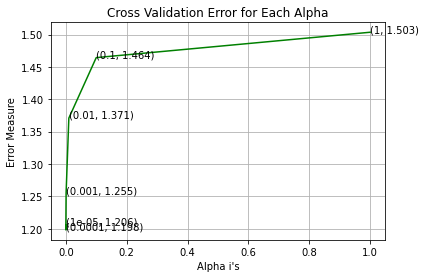

For values of best alpha = 0.0001 The train log loss is: 0.9848560284200811
For values of best alpha = 0.0001 The cross validation log loss is: 1.198202365594352
For values of best alpha = 0.0001 The test log loss is: 1.1786955163124564


In [30]:
alpha = [10 ** x for x in range(-5, 1)] #hyperparameter for SGD_classifier

cv_log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42) #loss_'log'_>>logistic_regression
    clf.fit(train_gene_feature_onehotCoding, y_train) #one_hot encoded feature
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid") 
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding) #transforming the values to probabilities
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    
    print('For values of alpha =', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
    
plt.grid()
plt.title("Cross Validation Error for Each Alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error Measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha =',alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha =',alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha =',alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

**<font color=red>Ques: Is the gene feature stable across all the data sets (Test, Train, Cross Validation) ?</font>**

<b>Ans:</b> Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error.

In [31]:
print("How many data points in Test and CV datasets are covered by the",unique_genes.shape[0], "genes in train dataset ?")

test_coverage = X_test[X_test['Gene'].isin(list(set(X_train['Gene'])))].shape[0]
cv_coverage = x_cv[x_cv['Gene'].isin(list(set(X_train['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage,'out of',X_test.shape[0], ":",(test_coverage/X_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',x_cv.shape[0],":" ,(cv_coverage/x_cv.shape[0])*100)

How many data points in Test and CV datasets are covered by the 244 genes in train dataset ?
Ans
1. In test data 654 out of 665 : 98.34586466165413
2. In cross validation data 521 out of  532 : 97.93233082706767


**<font color=blue>Univariate Analysis on Variation Feature</font>**
- Variation is the **Categorical** variable (feature).

In [32]:
#to check how many categories are there;
unique_var = X_train['Variation'].value_counts()
print('NUMBER OF UNIQUE VARIATION: ',unique_var.shape[0])

#top 10 variation that occured most;
print(unique_var.head(10))

NUMBER OF UNIQUE VARIATION:  1929
Truncating_Mutations    59
Deletion                54
Amplification           49
Fusions                 17
Overexpression           3
F384L                    2
V321M                    2
T58I                     2
G12V                     2
E17K                     2
Name: Variation, dtype: int64


In [33]:
print("There are", unique_var.shape[0] ,"different categories of variation in the train data, and they are distibuted as follows:")

There are 1929 different categories of variation in the train data, and they are distibuted as follows:


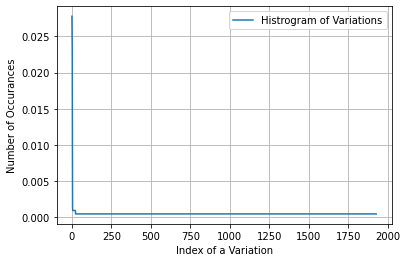

In [34]:
s = sum(unique_var.values);
h = unique_var.values/s;

plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

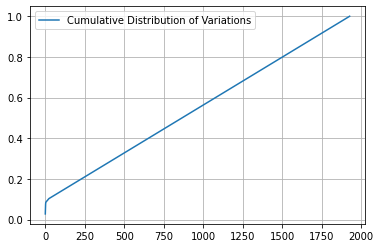

In [35]:
#cdf
c = np.cumsum(h)

plt.plot(c,label='Cumulative Distribution of Variations')
plt.grid()
plt.legend()
plt.show()

**<font color=blue>Featurizing Variation Feature</font>**

_There are two ways of featurize this variable:_
1. One Hot Encoding
2. Response Coding

We will be using both these methods to featurize the Variation Feature.

In [36]:
#response_coding of the variation feature

alpha = 1 #alpha is used for laplace smoothing

#train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", X_train))

#test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", X_test))

#cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", x_cv))

In [37]:
print("Train Variation Feature is Converted using Respone Coding Method. The Shape of Variation Feature:", train_variation_feature_responseCoding.shape)

Train Variation Feature is Converted using Respone Coding Method. The Shape of Variation Feature: (2124, 9)


In [38]:
#one_hot encoding of variation feature

variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(X_train['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(X_test['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(x_cv['Variation'])

In [39]:
print("Train Variation Feature is Converted using One Hot Encoding Method. The Shape of Variation Feature:", train_variation_feature_onehotCoding.shape)

Train Variation Feature is Converted using One Hot Encoding Method. The Shape of Variation Feature: (2124, 1958)


**<font color=red>Ques: How good is this variation feature in predicting y_i ?</font>**

_Let's build a model just like the earlier!_

For values of alpha = 1e-05 The log loss is: 1.7177636914609644
For values of alpha = 0.0001 The log loss is: 1.7086921832686752
For values of alpha = 0.001 The log loss is: 1.7146765233235282
For values of alpha = 0.01 The log loss is: 1.7211462170152163
For values of alpha = 0.1 The log loss is: 1.736385284965914
For values of alpha = 1 The log loss is: 1.7381905443389045


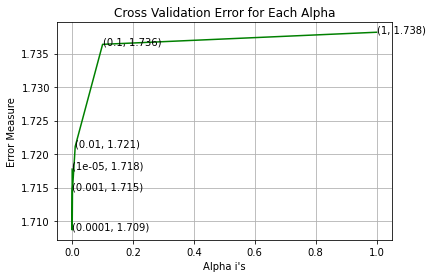

For values of best alpha = 0.0001 The train log loss is: 0.6714795558405287
For values of best alpha = 0.0001 The cross validation log loss is: 1.7086921832686752
For values of best alpha = 0.0001 The test log loss is: 1.6880062317136189


In [40]:
alpha = [10 ** x for x in range(-5, 1)] #hyperparameter for SGD_classifier

cv_log_error_array=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42) #loss_'log'_>>logistic_regression
    clf.fit(train_variation_feature_onehotCoding, y_train) #one_hot encoded feature
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid") 
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding) #transforming the values to probabilities
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    
    print('For values of alpha =', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
    
plt.grid()
plt.title("Cross Validation Error for Each Alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error Measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha =',alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha =',alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha =',alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

**<font color=red>Ques: Is the variation feature stable across all the data sets (Test, Train, Cross Validation) ?</font>**

<b>Ans:</b> Not sure! But lets be very sure using the below analysis.

In [41]:
print("How many data points in Test and CV datasets are covered by the",unique_var.shape[0], "genes in train dataset ?")

test_coverage = X_test[X_test['Variation'].isin(list(set(X_train['Variation'])))].shape[0]
cv_coverage = x_cv[x_cv['Variation'].isin(list(set(X_train['Variation'])))].shape[0]

print('Ans\n1. In test data',test_coverage,'out of',X_test.shape[0], ":",(test_coverage/X_test.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',x_cv.shape[0],":" ,(cv_coverage/x_cv.shape[0])*100)

How many data points in Test and CV datasets are covered by the 1929 genes in train dataset ?
Ans
1. In test data 73 out of 665 : 10.977443609022556
2. In cross validation data 52 out of  532 : 9.774436090225564


**<font color=blue>Univariate Analysis on Text Feature</font>**
- Variation is the **Text** variable (feature).

1. How many unique words are present in train data ?
2. How are word frequencies distributed ?
3. How to featurize text field ?
4. Is the text feature useful in predicitng y_i ?
5. Is the text feature stable across train, test and CV datasets ? 

In [42]:
def extract_dictionary_paddle(cls_text): #cls_text is a data frame
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows(): #for every row in data fram consider the 'TEXT'
        for word in row['TEXT'].split(): #split the words by space
            dictionary[word] +=1 #make a dict with those word and increment its count whenever we see that word
    return dictionary

In [43]:
#ref: https://stackoverflow.com/a/1602964

def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [44]:
#building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(X_train['TEXT'])

#getting all the feature names (words)
train_text_features = text_vectorizer.get_feature_names()

#train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

#zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))

print("Total Number of Unique Words in Train Data :",len(train_text_features))

Total Number of Unique Words in Train Data : 53763


In [45]:
dict_list = [] #contains 9 dictoinaries each corresponds to a class

for i in range(1,10):
    cls_text = X_train[X_train['Class']==i]
    #build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    #append it to dict_list

#dict_list[i] is build on i'th class text data
#total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(X_train)

confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [46]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(X_train)
test_text_feature_responseCoding  = get_text_responsecoding(X_test)
cv_text_feature_responseCoding  = get_text_responsecoding(x_cv)

In [47]:
#ref: https://stackoverflow.com/a/16202486
#we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [48]:
#don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

#we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(X_test['TEXT'])

#don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

#we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(x_cv['TEXT'])

#don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [49]:
#sort dictionary by value - https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1], reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [50]:
#number of words for a given frequency
print(Counter(sorted_text_occur))

Counter({3: 5528, 4: 3413, 5: 3342, 6: 3040, 7: 2000, 8: 1820, 9: 1716, 12: 1505, 10: 1449, 11: 1074, 13: 1038, 15: 928, 14: 802, 16: 782, 18: 764, 20: 578, 17: 571, 24: 529, 21: 516, 22: 514, 19: 466, 23: 437, 25: 418, 27: 413, 30: 367, 37: 358, 26: 353, 28: 319, 32: 316, 29: 308, 36: 277, 33: 269, 55: 268, 31: 251, 35: 239, 34: 225, 38: 212, 40: 210, 39: 202, 42: 196, 43: 194, 41: 187, 45: 186, 46: 184, 48: 176, 44: 175, 54: 158, 49: 156, 57: 153, 47: 149, 51: 148, 60: 147, 56: 146, 50: 145, 52: 143, 53: 131, 59: 128, 61: 119, 62: 116, 58: 114, 64: 111, 68: 108, 72: 105, 66: 104, 69: 96, 71: 93, 86: 91, 70: 90, 80: 89, 65: 89, 63: 89, 67: 87, 75: 85, 73: 85, 78: 83, 77: 82, 85: 81, 84: 81, 92: 79, 79: 78, 90: 76, 110: 75, 83: 73, 74: 73, 88: 72, 82: 70, 76: 70, 87: 66, 115: 61, 104: 61, 95: 61, 93: 61, 100: 60, 91: 58, 99: 57, 96: 57, 102: 56, 97: 55, 89: 55, 113: 53, 111: 53, 101: 53, 81: 53, 130: 52, 98: 52, 105: 51, 94: 48, 126: 47, 114: 46, 109: 45, 136: 44, 108: 44, 131: 43, 127

For values of alpha = 1e-05 The log loss is: 1.350494048841146
For values of alpha = 0.0001 The log loss is: 1.26064961531178
For values of alpha = 0.001 The log loss is: 1.2819656821857222
For values of alpha = 0.01 The log loss is: 1.3968568506848185
For values of alpha = 0.1 The log loss is: 1.497087360379039
For values of alpha = 1 The log loss is: 1.6545582340325038


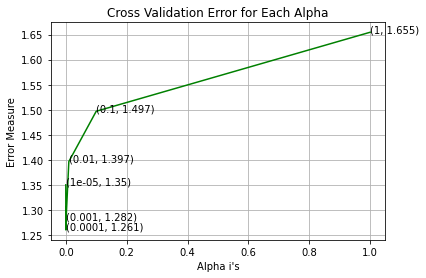

For values of best alpha = 0.0001 The train log loss is: 0.640628642466798
For values of best alpha = 0.0001 The cross validation log loss is: 1.26064961531178
For values of best alpha = 0.0001 The test log loss is: 1.145505626258567


In [51]:
#train a logistic regression + calibration model using text features which are one-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    
    print('For values of alpha =',i,"The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
    
plt.grid()
plt.title("Cross Validation Error for Each Alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error Measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha =', alpha[best_alpha],"The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha =', alpha[best_alpha],"The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha =', alpha[best_alpha],"The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

**<font color=red>Ques: Is the Text feature stable across all the data sets (Test, Train, Cross Validation) ?</font>**

<b>Ans:</b> Yes, it seems like!

In [52]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [53]:
len1,len2 = get_intersec_text(X_test)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data.")

len1,len2 = get_intersec_text(x_cv)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data.")

96.879 % of word of test data appeared in train data.
98.551 % of word of Cross Validation appeared in train data.


**<font color=green><h2>Machine Learning Models</h2></font>**

In [54]:
#data preparation for ML models

def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    
    pred_y = sig_clf.predict(test_x)

    #for calculating log_loss we will provide the array of probabilities belongs to each class
    print("Log Loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    
    #calculating the number of data points that are misclassified
    print("Number of Mis-classified Points:", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    
    plot_confusion_matrix(test_y, pred_y) #plot_confusion_matrix

In [55]:
#this function will be used just for naive bayes

#for the given indices, we will print the name of the features
#and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(X_train['Gene'])
    var_vec  = var_count_vec.fit(X_train['Variation'])
    text_vec = text_count_vec.fit(X_train['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top",no_features,"features",word_present,"are present in query point.")

**<font color=blue>Stacking all the three types of features</font>**

In [56]:
#merging one-hot encoded gene, variance and text features
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(X_train['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(X_test['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(x_cv['Class']))

In [57]:
print("One Hot Encoding Features :")
print("(Number of Data points * Number of Features) in Train Data =", train_x_onehotCoding.shape)
print("(Number of Data points * Number of Features) in Test Data =", test_x_onehotCoding.shape)
print("(Number of Data points * Number of Features) in Cross Validation Data =", cv_x_onehotCoding.shape)

One Hot Encoding Features :
(Number of Data points * Number of Features) in Train Data = (2124, 55964)
(Number of Data points * Number of Features) in Test Data = (665, 55964)
(Number of Data points * Number of Features) in Cross Validation Data = (532, 55964)


In [58]:
#merging response coded gene, variance and text features

train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [59]:
print("Response Encoding Features :")
print("(Number of Data points * Number of Features) in Train Data =", train_x_responseCoding.shape)
print("(Number of Data points * Number of Features) in Test Data =", test_x_responseCoding.shape)
print("(Number of Data points * Number of Features) in Cross Validation Data =", cv_x_responseCoding.shape)

Response Encoding Features :
(Number of Data points * Number of Features) in Train Data = (2124, 27)
(Number of Data points * Number of Features) in Test Data = (665, 27)
(Number of Data points * Number of Features) in Cross Validation Data = (532, 27)


**<h2><font color=green>Base Line Model -</font><font color=red> Naive Bayes</font></h2>**

**<font color=blue>Hyper Parameter Tuning</font>**

for alpha = 1e-05
Log Loss : 1.3311551279524751
for alpha = 0.0001
Log Loss : 1.3174800482092577
for alpha = 0.001
Log Loss : 1.3076371213592408
for alpha = 0.1
Log Loss : 1.3007206002522484
for alpha = 1
Log Loss : 1.3331066316159332
for alpha = 10
Log Loss : 1.4063094049262224
for alpha = 100
Log Loss : 1.419108488457189
for alpha = 1000
Log Loss : 1.441366526254924


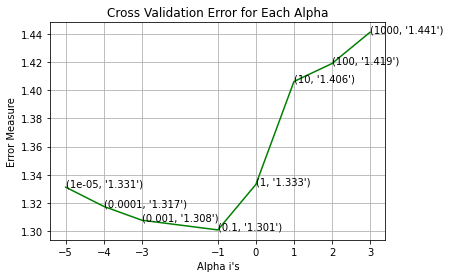

For values of best alpha = 0.1 The train log loss is: 0.8398433970790349
For values of best alpha = 0.1 The cross validation log loss is: 1.3007206002522484
For values of best alpha = 0.1 The test log loss is: 1.278702952397464


In [60]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]

cv_log_error_array = []

for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y) #naive bayes can handle large dimensionality, so that we take one_hot_encoded_feature
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    #to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
    
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for Each Alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error Measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha =', alpha[best_alpha],"The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha =', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha =', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

**<font color=blue>Testing the Model with Best Hyper Paramter</font>**

Log Loss : 1.3007206002522484
Number of Mis-classified Points : 0.41729323308270677
---------------------------------------- Confusion Matrix ----------------------------------------


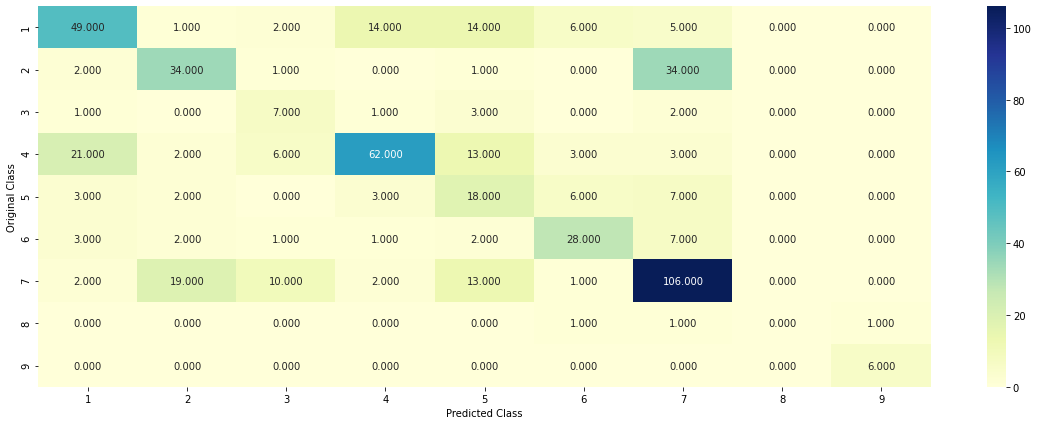

---------------------------------------- Precision Matrix (Columm Sum=1) ----------------------------------------


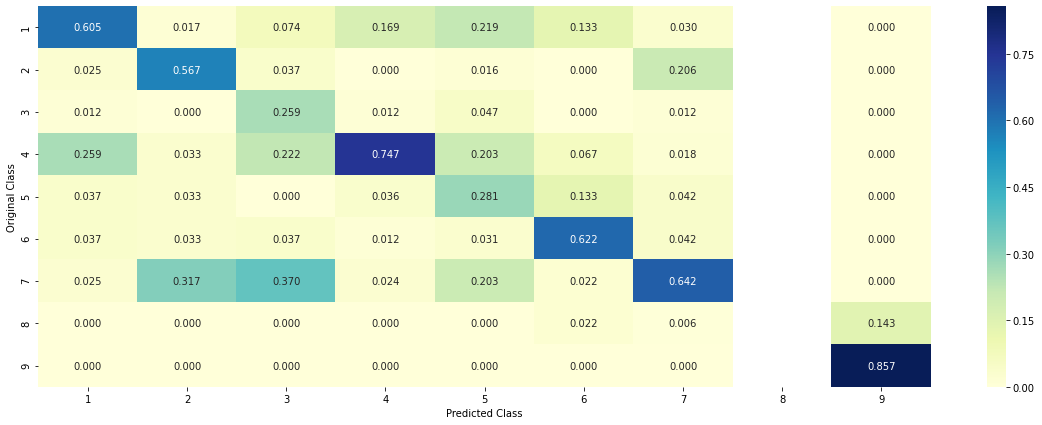

---------------------------------------- Recall Matrix (Row Sum=1) ----------------------------------------


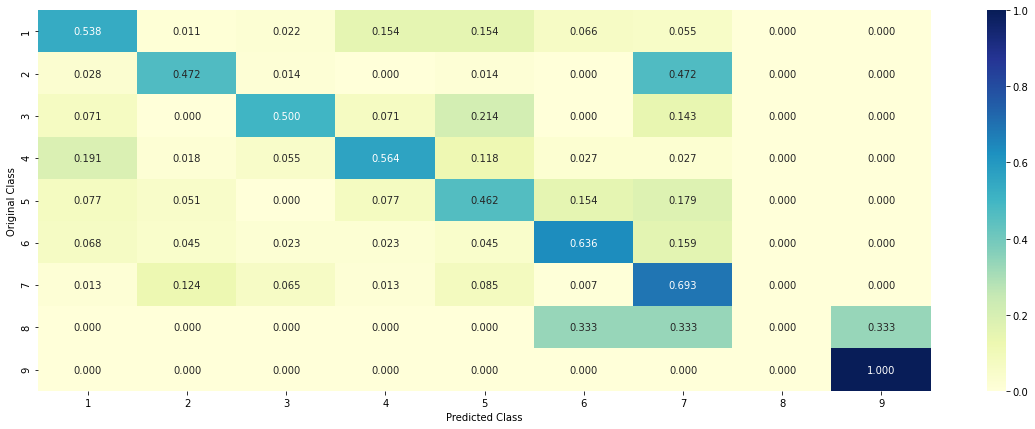

In [61]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
#to avoid rounding error while multiplying probabilites we use log-probability estimates

print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of Mis-classified Points :",np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])

plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [62]:
#precision_matrix
#Of all the points which predicted to be class 4 (y_i_hat = 4), 74.7% of points are actually belongs to class 4.
#Of all the points which predicted to be class 2 (y_i_hat = 2), 31.7% of points are actually belongs to class 7.

#recall_matrix
#Of all the points which are originally belongs to class 7 (y_i = 7), 69.3% of points were classified to class 7.
#Of all the points which are originally belongs to class 2 (y_i = 2), 47.2% of points were classified to class 7.

In [ ]:
#sample_query_point1_(correctly classified pt)
test_point_index = 1
no_feature = 100

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])

print("Predicted Class :",predicted_cls[0])
print("Predicted Class Probabilities:",np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :",test_y[test_point_index])

indices = np.argsort(-1*clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*100)
#interpretability 
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index], X_test['Gene'].iloc[test_point_index], X_test['Variation'].iloc[test_point_index], no_feature)

In [64]:
X_test['TEXT'].iloc[test_point_index]

'effect series mutations transforming potential normal human rash compared effects gtpase guanine nucleotide exchange rates p21 mutation val 146 resulted partial activation transforming potential could attributed 1 000 fold increased rate nucleotide exchange absence effect gtpase contrast modest enhancement exchange rate 100 fold resulted mutation met 14 affect biological activity partially activating mutation thr 59 found result 5 fold reduction gtpase 10 fold increase nucleotide exchange however nontransforming mutant ile 59 displayed comparable decrease gtpase without effect nucleotide exchange activating effect thr 59 mutation may thus represent combined effect reduced gtpase increased exchange similarly strongly activating mutation leu 61 resulted fivefold increase nucleotide exchange addition decreased gtpase whereas weakly activating mutations position 61 trp pro resulted decreased gtpase without affecting nucleotide exchange rates finally combining two mutations met 14 ile 59 a

In [65]:
X_test['Gene'].iloc[test_point_index]

'KRAS'

In [66]:
X_test['Variation'].iloc[test_point_index]

'A146V'

In [67]:
clf.coef_.shape

(9, 55964)

In [68]:
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]

indices[0]

array([27981, 32912, 32911, 32908, 32906, 32905, 10867, 32900, 10869,
       10870, 10871, 32898, 10873, 32915, 32897, 10878, 10879, 10880,
       10881, 10883, 32891, 10885, 32890, 10887, 10889, 10891, 32872,
       10875, 10860, 10859, 10858, 10828, 32984, 32975, 32965, 32963,
       32961, 32959, 32958, 32953, 32948, 32947, 32946, 32945, 10843,
       10844, 10845, 10846, 32944, 10848, 32943, 32942, 32940, 10852,
       10853, 32934, 32927, 32917, 32871, 32989, 32870, 32867, 10935,
       32732, 32720, 32716, 32712, 32711, 32708, 32703, 32678, 32677,
       10945, 32674, 32738, 32673, 10949, 32670, 32669, 32667, 32663,
       10954, 32661, 10958, 32657, 32654, 32653, 32650, 32671, 10933,
       32741, 32747, 32866, 32864, 32862, 10902, 32859, 32856, 32839,
       10910], dtype=int64)

In [69]:
#sample_query_point2_(incorrectly classified pt)
test_point_index = 0
no_feature = 100
    
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
    
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
    
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:]
#print("-"*100)
#get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index], X_test['Gene'].iloc[test_point_index].lower(), X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0703 0.0627 0.0133 0.6771 0.0289 0.0292 0.1104 0.0044 0.0036]]
Actual Class : 4


**<h2><font color=red>K Nearest Neighbour Classification</font></h2>**

**<font color=blue>Hyper Parameter Tuning</font>**

for alpha = 5
Log Loss : 1.0827495335270478
for alpha = 11
Log Loss : 1.0831266042828556
for alpha = 15
Log Loss : 1.0882464674434487
for alpha = 21
Log Loss : 1.1006127339569989
for alpha = 31
Log Loss : 1.105003492167865
for alpha = 41
Log Loss : 1.1014810694783306
for alpha = 51
Log Loss : 1.1113503847580524
for alpha = 99
Log Loss : 1.136360449094103


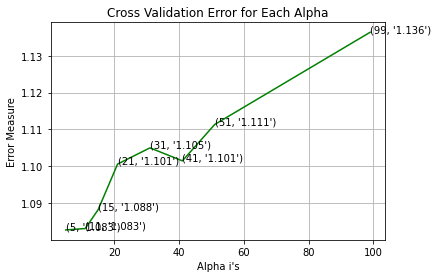

For values of best alpha = 5 The train log loss is: 0.4383223895940398
For values of best alpha = 5 The cross validation log loss is: 1.0827495335270478
For values of best alpha = 5 The test log loss is: 1.0670714689965017


In [70]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]

cv_log_error_array = []

for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i) 
    clf.fit(train_x_responseCoding, train_y) #knn may not good at handling large dimensionality, so that we take response_encoded_feature
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    #to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for Each Alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error Measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha =', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha =', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha =', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

**<font color=blue>Testing the Model with Best Hyper Paramter</font>**

Log Loss : 1.0827495335270478
Number of Mis-classified Points: 0.3609022556390977
---------------------------------------- Confusion Matrix ----------------------------------------


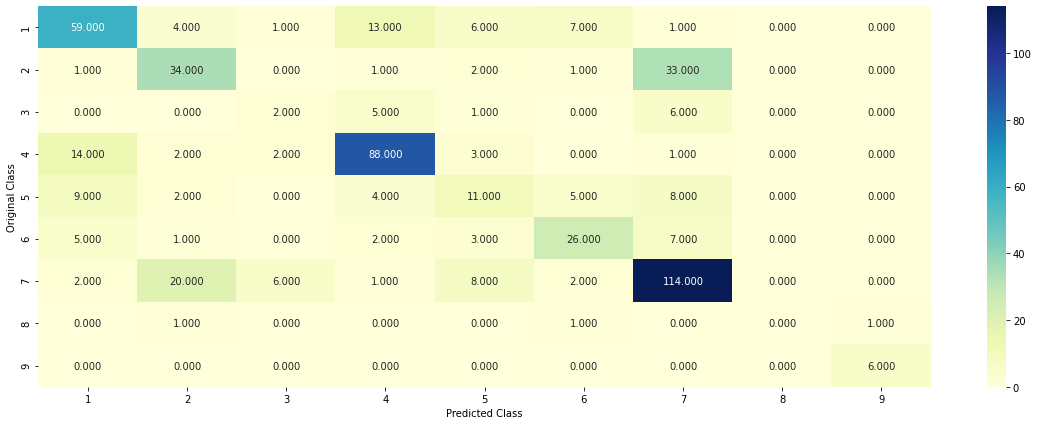

---------------------------------------- Precision Matrix (Columm Sum=1) ----------------------------------------


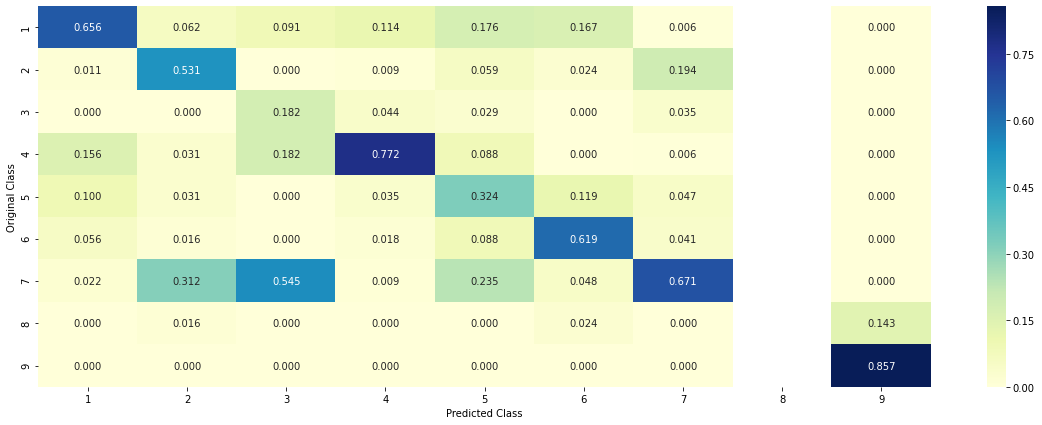

---------------------------------------- Recall Matrix (Row Sum=1) ----------------------------------------


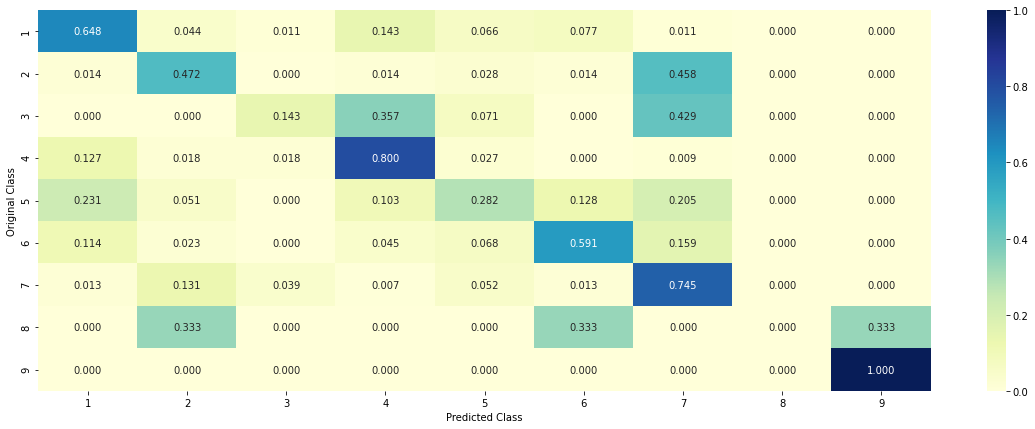

In [71]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])

predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [72]:
#precision_matrix
#Of all the points which predicted to be class 7 (y_i_hat = 7), 67.1% of points are actually belongs to class 7.
#Of all the points which predicted to be class 3 (y_i_hat = 3), 54.5% of points are actually belongs to class 7.

#recall_matrix
#Of all the points which are originally belongs to class 9 (y_i = 9), 100% of points were classified to class 9.
#Of all the points which are originally belongs to class 3 (y_i = 3), 35.7% of points were classified to class 4.

In [73]:
#sample_query_point
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 30
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))

print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])

neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])

print("The",alpha[best_alpha],"nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of Nearest Points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 7
The 5 nearest neighbours of the test points belongs to classes [7 7 7 7 7]
Fequency of Nearest Points : Counter({7: 5})


In [74]:
#sample_query_point
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 50
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))

print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])

neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])

print("The k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of Nearest Points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 5
Actual Class : 5
The k value for knn is 5 and the nearest neighbours of the test points belongs to classes [5 5 5 5 5]
Fequency of Nearest Points : Counter({5: 5})


**<h2><font color=red>Logistic Regression</font></h2>**

(With Class Balancing)

**<font color=blue>Hyper Parameter Tuning</font>**

for alpha = 1e-06
Log Loss : 1.3986064343225957
for alpha = 1e-05
Log Loss : 1.3759207985525415
for alpha = 0.0001
Log Loss : 1.2266930364073565
for alpha = 0.001
Log Loss : 1.2282325715902527
for alpha = 0.01
Log Loss : 1.2940373780833088
for alpha = 0.1
Log Loss : 1.4798544681430172
for alpha = 1
Log Loss : 1.7012654521814154
for alpha = 10
Log Loss : 1.7286976714427011
for alpha = 100
Log Loss : 1.7315916296293479


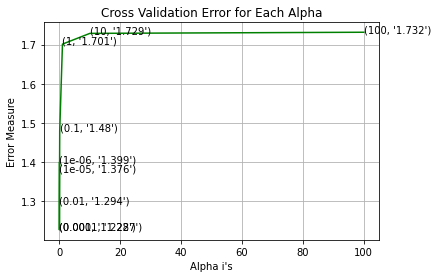

For values of best alpha = 0.0001 The train log loss is: 0.4858453013431955
For values of best alpha = 0.0001 The cross validation log loss is: 1.2266930364073565
For values of best alpha = 0.0001 The test log loss is: 1.0634476932345598


In [75]:
alpha = [10 ** x for x in range(-6, 3)]

cv_log_error_array = []

for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42) #class_weight='balanced'
    clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    #to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
    
plt.grid()
plt.title("Cross Validation Error for Each Alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error Measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)

clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha =', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha =', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha =', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

**<font color=blue>Testing the Model with Best Hyper Paramter</font>**

Log Loss : 1.2266930364073565
Number of Mis-classified Points: 0.36654135338345867
---------------------------------------- Confusion Matrix ----------------------------------------


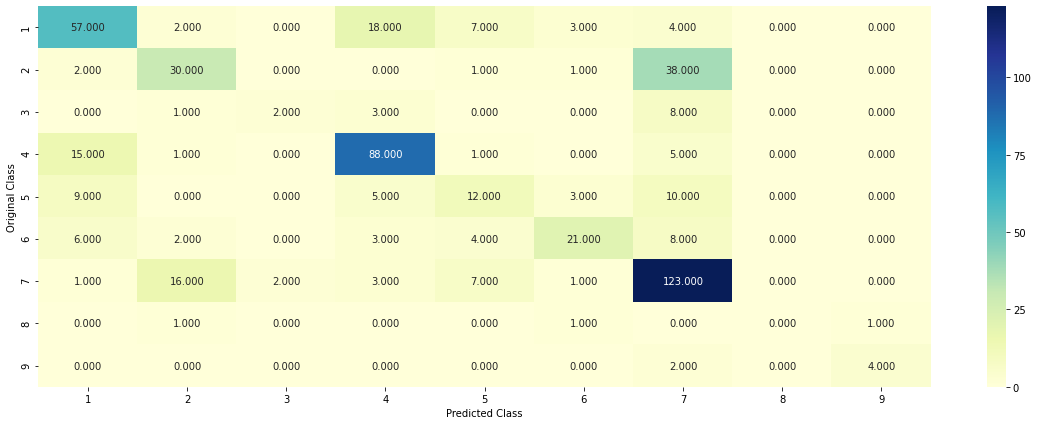

---------------------------------------- Precision Matrix (Columm Sum=1) ----------------------------------------


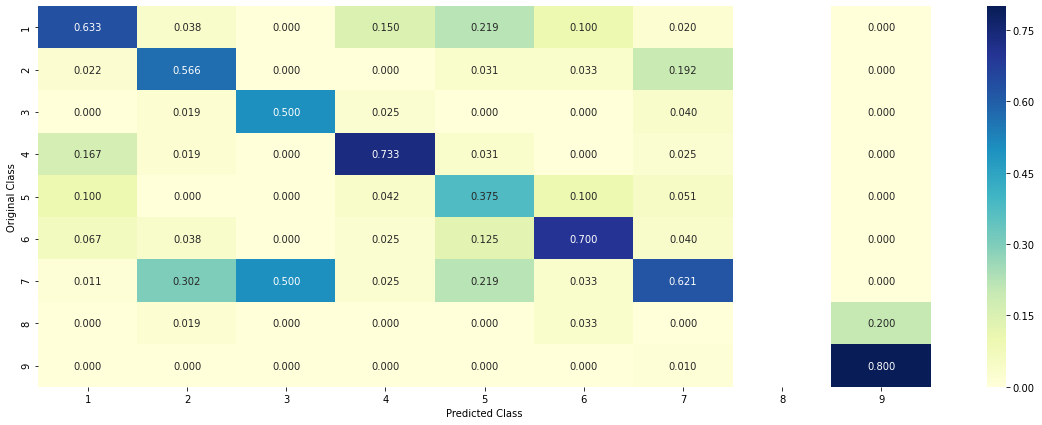

---------------------------------------- Recall Matrix (Row Sum=1) ----------------------------------------


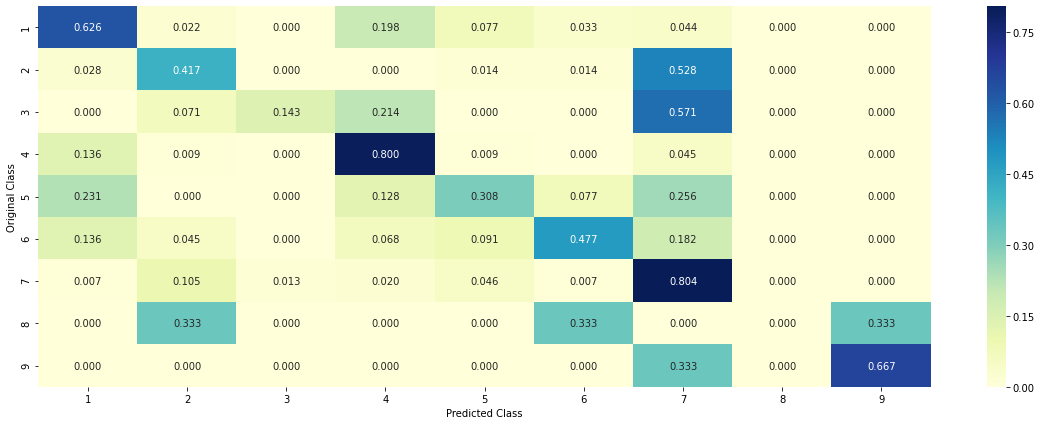

In [76]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)

predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [77]:
#precision_matrix
#Of all the points which predicted to be class 4 (y_i_hat = 4), 73.3% of points are actually belongs to class 4.
#Of all the points which predicted to be class 2 (y_i_hat = 2), 30.2% of points are actually belongs to class 7.

#recall_matrix
#Of all the points which are originally belongs to class 1 (y_i = 1), 62.6% of points were classified to class 1.
#Of all the points which are originally belongs to class 3 (y_i = 3), 21.4% of points were classified to class 4.

In [78]:
#sample query point (correctly classified point)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)

test_point_index = 1
no_feature = 500

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])

print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index] ,X_test['Gene'].iloc[test_point_index], X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0588 0.0463 0.0083 0.0625 0.0216 0.1444 0.6423 0.0072 0.0084]]
Actual Class : 7
--------------------------------------------------
230 Text feature [3t3] present in test data point [True]
248 Text feature [2473] present in test data point [True]
259 Text feature [transforming] present in test data point [True]
290 Text feature [calu] present in test data point [True]
362 Text feature [transformation] present in test data point [True]
375 Text feature [501] present in test data point [True]
399 Text feature [transformed] present in test data point [True]
Out of the top 500 features 7 are present in query point.


In [79]:
#sample query point (in_correctly classified point)
test_point_index = 112
no_feature = 500

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])

print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index], X_test['Gene'].iloc[test_point_index], X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[2.031e-01 1.610e-02 6.000e-04 7.604e-01 1.500e-03 5.000e-04 8.100e-03
  5.100e-03 4.500e-03]]
Actual Class : 4
--------------------------------------------------
342 Text feature [nonidet] present in test data point [True]
440 Text feature [degrade] present in test data point [True]
Out of the top 500 features 2 are present in query point.


**<h2><font color=red>Logistic Regression</font></h2>**

(Without Class Balancing)

**<font color=blue>Hyper Parameter Tuning</font>**

for alpha = 1e-06
Log Loss : 1.3670132146651661
for alpha = 1e-05
Log Loss : 1.3294353409197694
for alpha = 0.0001
Log Loss : 1.2202198184524535
for alpha = 0.001
Log Loss : 1.220189781764762
for alpha = 0.01
Log Loss : 1.3324140296536386
for alpha = 0.1
Log Loss : 1.4439777979381128
for alpha = 1
Log Loss : 1.6090218859818537
for alpha = 10
Log Loss : 1.6415035643369693
for alpha = 100
Log Loss : 1.6450958278969452


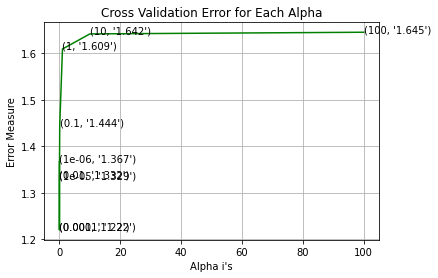

For values of best alpha = 0.001 The train log loss is: 0.4971941058295697
For values of best alpha = 0.001 The cross validation log loss is: 1.220189781764762
For values of best alpha = 0.001 The test log loss is: 1.0330092588321593


In [80]:
alpha = [10 ** x for x in range(-6, 3)]

cv_log_error_array = []

for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    #to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
    
plt.grid()
plt.title("Cross Validation Error for Each Alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error Measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha =', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha =', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha =', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

**<font color=blue>Testing the Model with Best Hyper Paramter</font>**

Log Loss : 1.220189781764762
Number of Mis-classified Points: 0.37030075187969924
---------------------------------------- Confusion Matrix ----------------------------------------


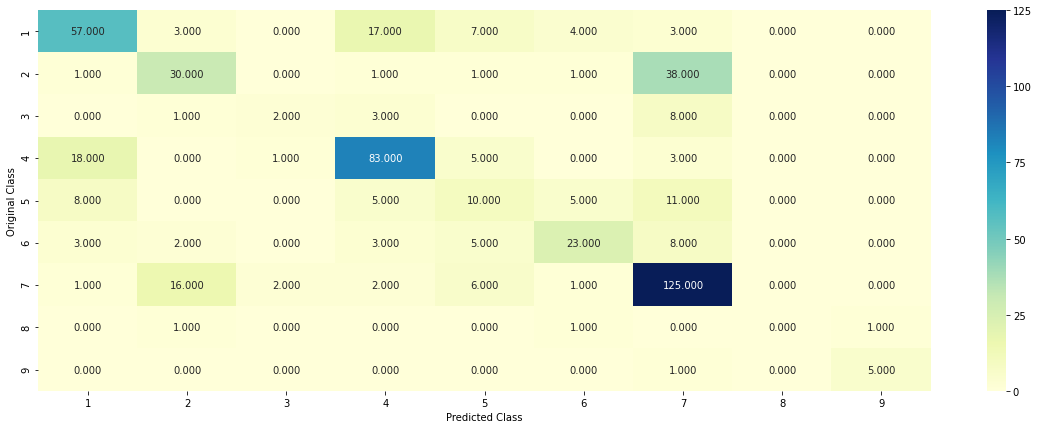

---------------------------------------- Precision Matrix (Columm Sum=1) ----------------------------------------


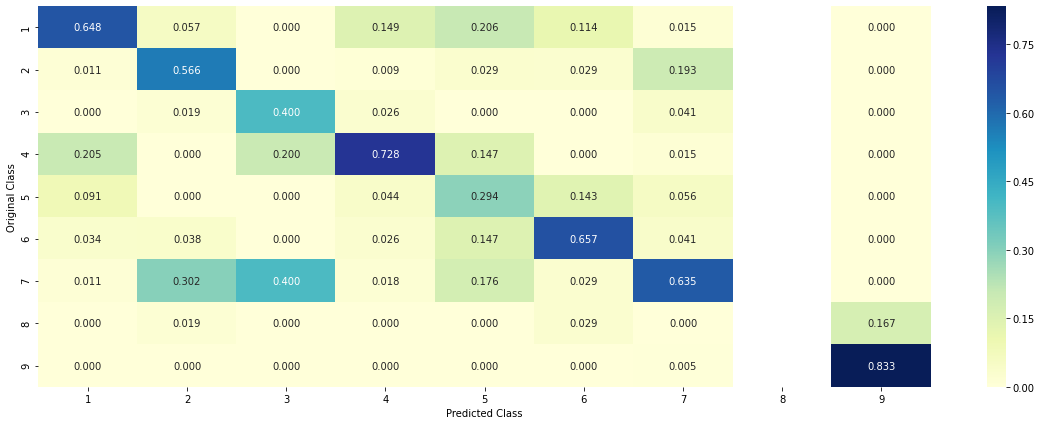

---------------------------------------- Recall Matrix (Row Sum=1) ----------------------------------------


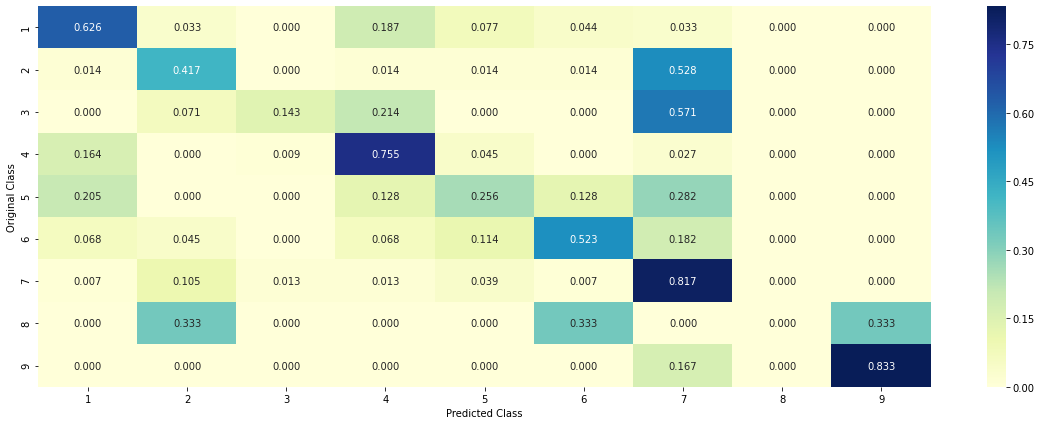

In [81]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)

predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [82]:
#precision_matrix
#Of all the points which predicted to be class 4 (y_i_hat = 4), 72.8% of points are actually belongs to class 4.
#Of all the points which predicted to be class 2 (y_i_hat = 2), 30.2% of points are actually belongs to class 7.

#recall_matrix
#Of all the points which are originally belongs to class 1 (y_i = 1), 62.6% of points were classified to class 1.
#Of all the points which are originally belongs to class 3 (y_i = 3), 21.4% of points were classified to class 4.

In [83]:
#feature importance_/_sample query point (correctly classified point)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)

test_point_index = 1
no_feature = 500

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index], X_test['Gene'].iloc[test_point_index], X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0439 0.052  0.0076 0.057  0.0209 0.0761 0.7334 0.0063 0.003 ]]
Actual Class : 7
--------------------------------------------------
90 Text feature [3t3] present in test data point [True]
129 Text feature [transforming] present in test data point [True]
145 Text feature [calu] present in test data point [True]
199 Text feature [constitutively] present in test data point [True]
210 Text feature [transformation] present in test data point [True]
246 Text feature [501] present in test data point [True]
257 Text feature [2473] present in test data point [True]
276 Text feature [transformed] present in test data point [True]
318 Text feature [triphosphatases] present in test data point [True]
387 Text feature [extracellular] present in test data point [True]
403 Text feature [activated] present in test data point [True]
Out of the top 500 features 11 are present in query point.


In [84]:
#feature importance_/_sample query point (in_correctly classified point)
test_point_index = 70
no_feature = 500

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index], X_test['Gene'].iloc[test_point_index], X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[2.600e-03 2.250e-02 1.000e-04 1.800e-02 4.000e-04 1.000e-04 9.518e-01
  4.400e-03 0.000e+00]]
Actual Class : 7
--------------------------------------------------
129 Text feature [transforming] present in test data point [True]
210 Text feature [transformation] present in test data point [True]
216 Text feature [constitutive] present in test data point [True]
222 Text feature [foundationone] present in test data point [True]
244 Text feature [oncogene] present in test data point [True]
246 Text feature [501] present in test data point [True]
276 Text feature [transformed] present in test data point [True]
302 Text feature [rac] present in test data point [True]
303 Text feature [infect] present in test data point [True]
387 Text feature [extracellular] present in test data point [True]
403 Text feature [activated] present in test data point [True]
427 Text feature [cubic] present in test data point [True]
429 Text feature [transform]

**<h2><font color=red>Linear Support Vector Machines</font></h2>**

**<font color=blue>Hyper Parameter Tuning</font>**

for C = 1e-05
Log Loss : 1.366925961763665
for C = 0.0001
Log Loss : 1.2937479093932778
for C = 0.001
Log Loss : 1.2283949874730387
for C = 0.01
Log Loss : 1.2714058032998732
for C = 0.1
Log Loss : 1.4032488679220727
for C = 1
Log Loss : 1.7198963640362714
for C = 10
Log Loss : 1.732097708011467
for C = 100
Log Loss : 1.7320975547478947


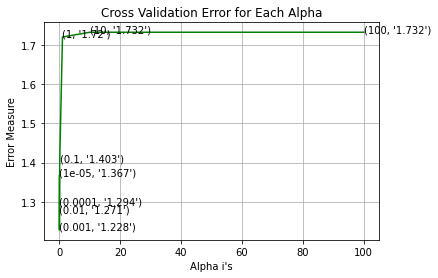

For values of best alpha = 0.001 The train log loss is: 0.5080811080746378
For values of best alpha = 0.001 The cross validation log loss is: 1.2283949874730387
For values of best alpha = 0.001 The test log loss is: 1.1330627723065267


In [85]:
alpha = [10 ** x for x in range(-5, 3)]

cv_log_error_array = []

for i in alpha:
    print("for C =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42) #loss='hinge'_>>>LSVM
    clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
    
plt.grid()
plt.title("Cross Validation Error for Each Alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error Measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)

clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha =', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha =', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha =', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

**<font color=blue>Testing the Model with Best Hyper Paramter</font>**

Log Loss : 1.2283949874730387
Number of Mis-classified Points: 0.40225563909774437
---------------------------------------- Confusion Matrix ----------------------------------------


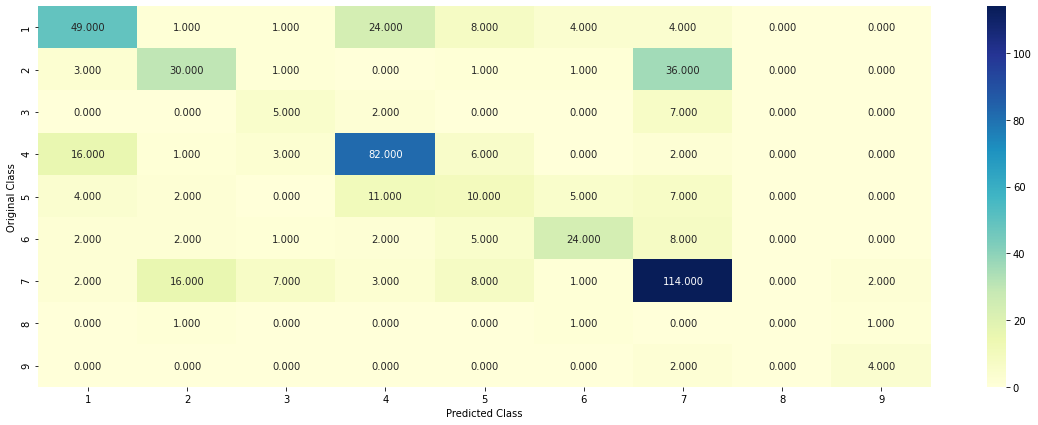

---------------------------------------- Precision Matrix (Columm Sum=1) ----------------------------------------


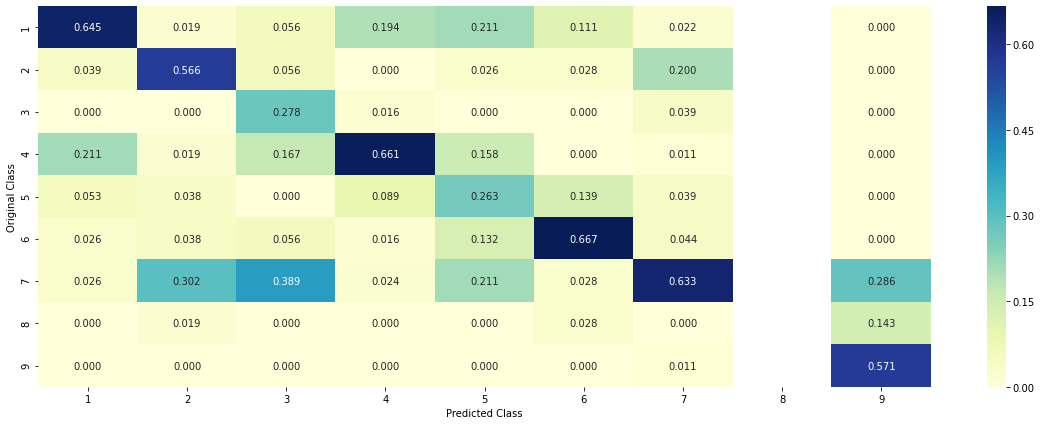

---------------------------------------- Recall Matrix (Row Sum=1) ----------------------------------------


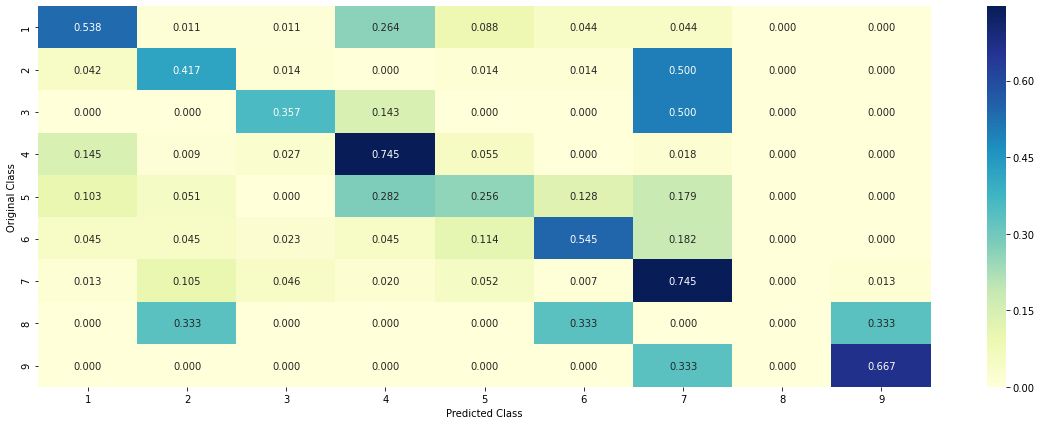

In [86]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)

predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [87]:
#precision_matrix
#Of all the points which predicted to be class 6 (y_i_hat = 6), 66.7% of points are actually belongs to class 6.
#Of all the points which predicted to be class 2 (y_i_hat = 2), 30.2% of points are actually belongs to class 7.

#recall_matrix
#Of all the points which are originally belongs to class 4 (y_i = 4), 74.5% of points were classified to class 4.
#Of all the points which are originally belongs to class 8 (y_i = 8), 33.3% of points were classified to class 6.

In [88]:
#feature importance_/_sample query point (correctly classified point)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)

test_point_index = 1
no_feature = 500

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index], X_test['Gene'].iloc[test_point_index], X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0718 0.0433 0.0099 0.0644 0.0304 0.3138 0.4552 0.0053 0.0058]]
Actual Class : 7
--------------------------------------------------
245 Text feature [2473] present in test data point [True]
305 Text feature [3t3] present in test data point [True]
315 Text feature [calu] present in test data point [True]
387 Text feature [transforming] present in test data point [True]
397 Text feature [transformation] present in test data point [True]
444 Text feature [501] present in test data point [True]
454 Text feature [transformed] present in test data point [True]
Out of the top 500 features 7 are present in query point.


In [89]:
#feature importance_/_sample query point (in_correctly classified point)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)

test_point_index = 70
no_feature = 500

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], X_test['TEXT'].iloc[test_point_index], X_test['Gene'].iloc[test_point_index], X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[2.260e-02 4.080e-02 7.000e-04 1.774e-01 6.700e-03 2.200e-03 7.430e-01
  4.000e-03 2.600e-03]]
Actual Class : 7
--------------------------------------------------
387 Text feature [transforming] present in test data point [True]
397 Text feature [transformation] present in test data point [True]
444 Text feature [501] present in test data point [True]
454 Text feature [transformed] present in test data point [True]
485 Text feature [foundationone] present in test data point [True]
Out of the top 500 features 5 are present in query point.


**<h2><font color=red>Random Forest Classifier</font></h2>**

**<font color=blue>Hyper Parameter Tuning -</font> (With One Hot Encoding)**

for n_estimators = 100 and max depth = 5
Log Loss : 1.2725840858615916
for n_estimators = 100 and max depth = 10
Log Loss : 1.1864600159045156
for n_estimators = 200 and max depth = 5
Log Loss : 1.2592675435083827
for n_estimators = 200 and max depth = 10
Log Loss : 1.1852145489241876
for n_estimators = 500 and max depth = 5
Log Loss : 1.2571418210977843
for n_estimators = 500 and max depth = 10
Log Loss : 1.175852767522888
for n_estimators = 1000 and max depth = 5
Log Loss : 1.2524521628431504
for n_estimators = 1000 and max depth = 10
Log Loss : 1.1763524747989864
for n_estimators = 2000 and max depth = 5
Log Loss : 1.2525052152530138
for n_estimators = 2000 and max depth = 10
Log Loss : 1.1755111785995898


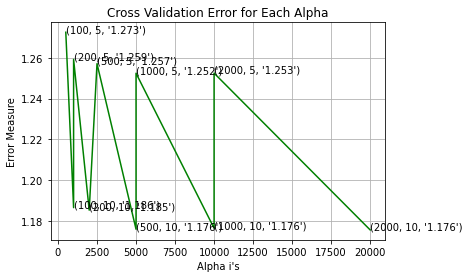

For values of best estimator = 2000 The train log loss is: 0.6597144629007261
For values of best estimator = 2000 The cross validation log loss is: 1.1755111785995895
For values of best estimator = 2000 The test log loss is: 1.145178998324195


In [90]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]

cv_log_error_array = []

for i in alpha:
    for j in max_depth:
        print("for n_estimators =",i,"and max depth =",j)
        
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')

for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
    
plt.grid()
plt.title("Cross Validation Error for Each Alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error Measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator =', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator =', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator =', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

**<font color=blue>Testing the Model with Best Hyper Paramter</font>**

Log Loss : 1.1755111785995895
Number of Mis-classified Points: 0.4191729323308271
---------------------------------------- Confusion Matrix ----------------------------------------


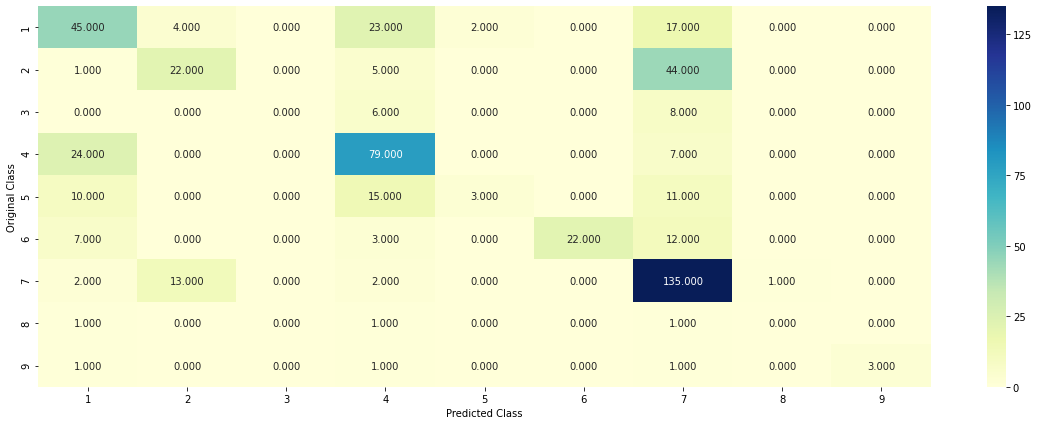

---------------------------------------- Precision Matrix (Columm Sum=1) ----------------------------------------


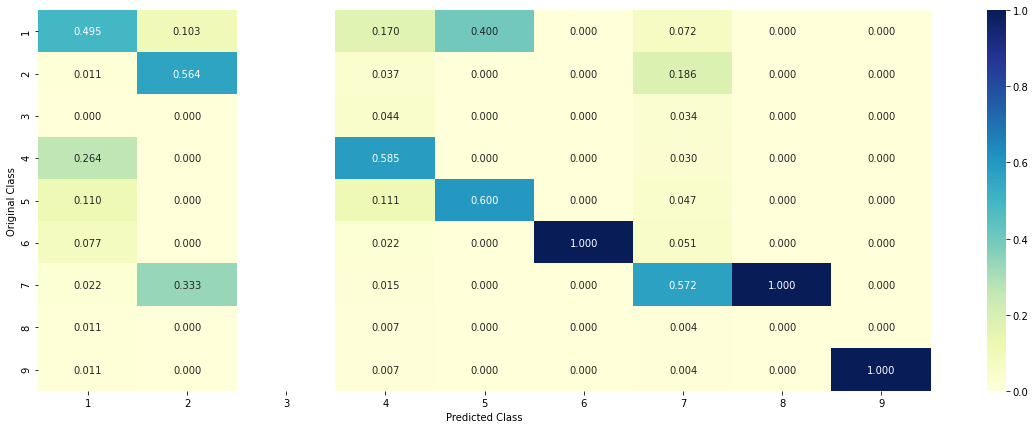

---------------------------------------- Recall Matrix (Row Sum=1) ----------------------------------------


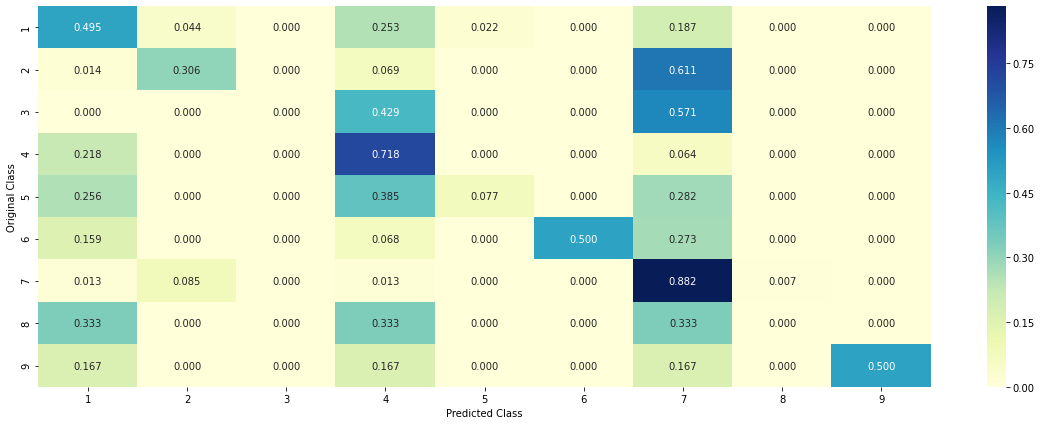

In [91]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)

predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [92]:
#precision_matrix
#Of all the points which predicted to be class 6 (y_i_hat = 6), 100% of points are actually belongs to class 6.
#Of all the points which predicted to be class 2 (y_i_hat = 2), 33.3% of points are actually belongs to class 7.

#recall_matrix
#Of all the points which are originally belongs to class 7 (y_i = 7), 88.2% of points were classified to class 7.
#Of all the points which are originally belongs to class 5 (y_i = 5), 38.5% of points were classified to class 4.

In [93]:
#feature importance_/_sample query point (correctly classified point)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], X_test['TEXT'].iloc[test_point_index], X_test['Gene'].iloc[test_point_index], X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0631 0.1002 0.0203 0.0726 0.0476 0.0405 0.6422 0.006  0.0074]]
Actual Class : 7
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
2 Text feature [activated] present in test data point [True]
3 Text feature [tyrosine] present in test data point [True]
4 Text feature [inhibitors] present in test data point [True]
5 Text feature [activation] present in test data point [True]
7 Text feature [function] present in test data point [True]
10 Text feature [treatment] present in test data point [True]
12 Text feature [phosphorylation] present in test data point [True]
13 Text feature [erk] present in test data point [True]
17 Text feature [signaling] present in test data point [True]
19 Text feature [kinases] present in test data point [True]
20 Text feature [inhibitor] present in test data point [True]
22 Text feature [ex

In [94]:
#feature importance_/_sample query point (in_correctly classified point)
test_point_index = 70
no_feature = 100

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], X_test['TEXT'].iloc[test_point_index], X_test['Gene'].iloc[test_point_index], X_test['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0659 0.1374 0.0167 0.065  0.0377 0.0317 0.6332 0.0056 0.0069]]
Actual Class : 7
--------------------------------------------------
0 Text feature [kinase] present in test data point [True]
1 Text feature [activating] present in test data point [True]
2 Text feature [activated] present in test data point [True]
3 Text feature [tyrosine] present in test data point [True]
4 Text feature [inhibitors] present in test data point [True]
5 Text feature [activation] present in test data point [True]
6 Text feature [constitutive] present in test data point [True]
7 Text feature [function] present in test data point [True]
9 Text feature [suppressor] present in test data point [True]
10 Text feature [treatment] present in test data point [True]
12 Text feature [phosphorylation] present in test data point [True]
14 Text feature [loss] present in test data point [True]
15 Text feature [oncogenic] present in test data point [True]
16 Text featur

**<font color=blue>Hyper Parameter Tuning -</font> (With Response Coding)**

In [95]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]

cv_log_error_array = []

for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)

clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha =', alpha[int(best_alpha/4)],"The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha =', alpha[int(best_alpha/4)],"The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha =', alpha[int(best_alpha/4)],"The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 1.984195364049222
for n_estimators = 10 and max depth =  3
Log Loss : 1.6758225888424847
for n_estimators = 10 and max depth =  5
Log Loss : 1.4943837453005286
for n_estimators = 10 and max depth =  10
Log Loss : 1.8865759140830134
for n_estimators = 50 and max depth =  2
Log Loss : 1.6803167527565204
for n_estimators = 50 and max depth =  3
Log Loss : 1.4790088491028388
for n_estimators = 50 and max depth =  5
Log Loss : 1.370819329186625
for n_estimators = 50 and max depth =  10
Log Loss : 1.7657011365735635
for n_estimators = 100 and max depth =  2
Log Loss : 1.5516241526399372
for n_estimators = 100 and max depth =  3
Log Loss : 1.4975594496639195
for n_estimators = 100 and max depth =  5
Log Loss : 1.3253304766842025
for n_estimators = 100 and max depth =  10
Log Loss : 1.7340464942267442
for n_estimators = 200 and max depth =  2
Log Loss : 1.6084956827953993
for n_estimators = 200 and max depth =  3
Log Loss : 1.5186126610201145

**<font color=blue>Testing the Model with Best Hyper Paramter</font>**

Log Loss : 1.3253304766842025
Number of Mis-classified Points: 0.4906015037593985
---------------------------------------- Confusion Matrix ----------------------------------------


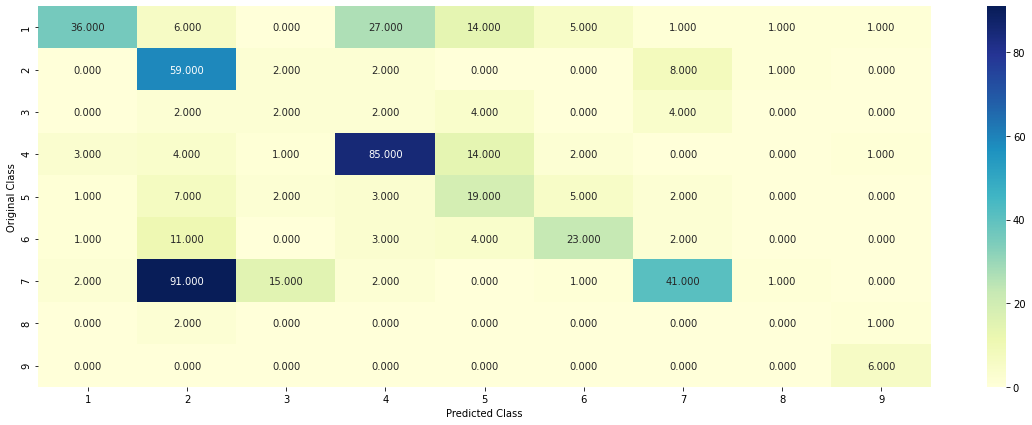

---------------------------------------- Precision Matrix (Columm Sum=1) ----------------------------------------


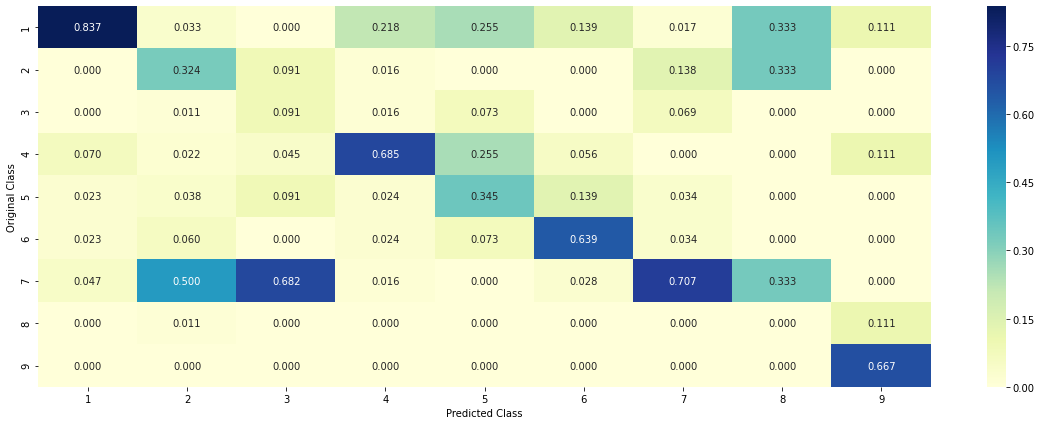

---------------------------------------- Recall Matrix (Row Sum=1) ----------------------------------------


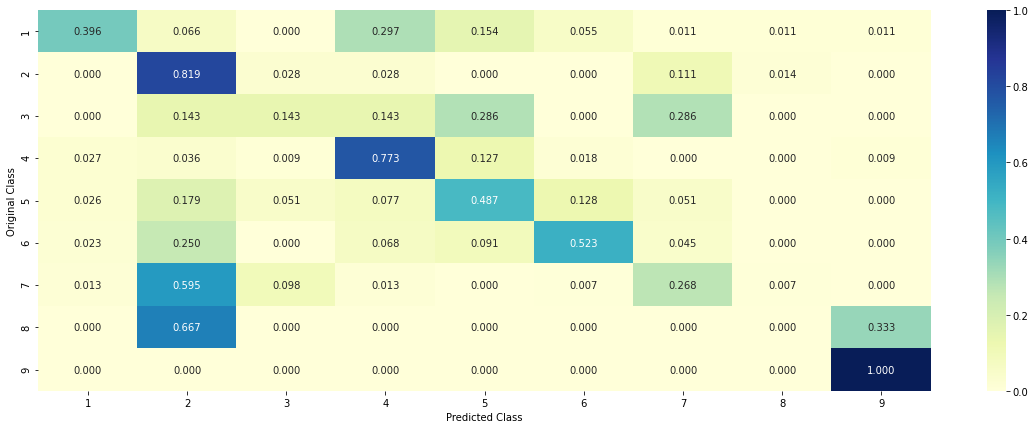

In [96]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)

predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

In [97]:
#precision_matrix
#Of all the points which predicted to be class 1 (y_i_hat = 1), 83.7% of points are actually belongs to class 1.
#Of all the points which predicted to be class 3 (y_i_hat = 3), 68.2% of points are actually belongs to class 7.

#recall_matrix
#Of all the points which are originally belongs to class 2 (y_i = 2), 81.9% of points were classified to class 2.
#Of all the points which are originally belongs to class 8 (y_i = 8), 66.7% of points were classified to class 2.

In [98]:
#feature importance_/_sample query point (correctly classified point)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)

sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
#no_feature = 25

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])

indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is Important Feature")
    elif i<18:
        print("Variation is Important Feature")
    else:
        print("Text is Important Feature")

Predicted Class : 7
Predicted Class Probabilities: [[0.025  0.213  0.192  0.0266 0.0404 0.068  0.3676 0.04   0.0274]]
Actual Class : 7
--------------------------------------------------
Variation is Important Feature
Variation is Important Feature
Variation is Important Feature
Variation is Important Feature
Gene is Important Feature
Variation is Important Feature
Variation is Important Feature
Text is Important Feature
Text is Important Feature
Gene is Important Feature
Text is Important Feature
Text is Important Feature
Text is Important Feature
Gene is Important Feature
Variation is Important Feature
Text is Important Feature
Gene is Important Feature
Gene is Important Feature
Variation is Important Feature
Gene is Important Feature
Text is Important Feature
Variation is Important Feature
Text is Important Feature
Text is Important Feature
Gene is Important Feature
Gene is Important Feature
Gene is Important Feature


In [99]:
#feature importance_/_sample query point (in_correctly classified point)
test_point_index = 78

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])

indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is Important Feature")
    elif i<18:
        print("Variation is Important Feature")
    else:
        print("Text is Important Feature")

Predicted Class : 4
Predicted Class Probabilities: [[0.233  0.0245 0.1117 0.4784 0.0321 0.0626 0.008  0.0217 0.028 ]]
Actual Class : 6
--------------------------------------------------
Variation is Important Feature
Variation is Important Feature
Variation is Important Feature
Variation is Important Feature
Gene is Important Feature
Variation is Important Feature
Variation is Important Feature
Text is Important Feature
Text is Important Feature
Gene is Important Feature
Text is Important Feature
Text is Important Feature
Text is Important Feature
Gene is Important Feature
Variation is Important Feature
Text is Important Feature
Gene is Important Feature
Gene is Important Feature
Variation is Important Feature
Gene is Important Feature
Text is Important Feature
Variation is Important Feature
Text is Important Feature
Text is Important Feature
Gene is Important Feature
Gene is Important Feature
Gene is Important Feature


**<h2><font color=red>Stacking Model</font></h2>**

**<font color=blue>Hyper Parameter Tuning</font>**

In [103]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0) #logistic_regression
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0) #linear_svm
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

clf3 = MultinomialNB(alpha=0.001) #naive_bayes
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression - Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))

sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support Vector Machines - Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))

sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes - Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))

print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999 #take_any_value

for i in alpha:
    lr = LogisticRegression(C=i)
    
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression - Log Loss: 1.23
Support Vector Machines - Log Loss: 1.72
Naive Bayes - Log Loss: 1.31
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.818
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.725
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.358
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.275
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.613
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 2.026


**<font color=blue>Testing the Model with Best Hyper Paramter</font>**

Log Loss (Train) on the stacking classifier : 0.48017013737567743
Log Loss (CV) on the stacking classifier : 1.2749924143445215
Log Loss (Test) on the stacking classifier : 1.1441992274872772
Number of Mis-classified Point : 0.3804511278195489
---------------------------------------- Confusion Matrix ----------------------------------------


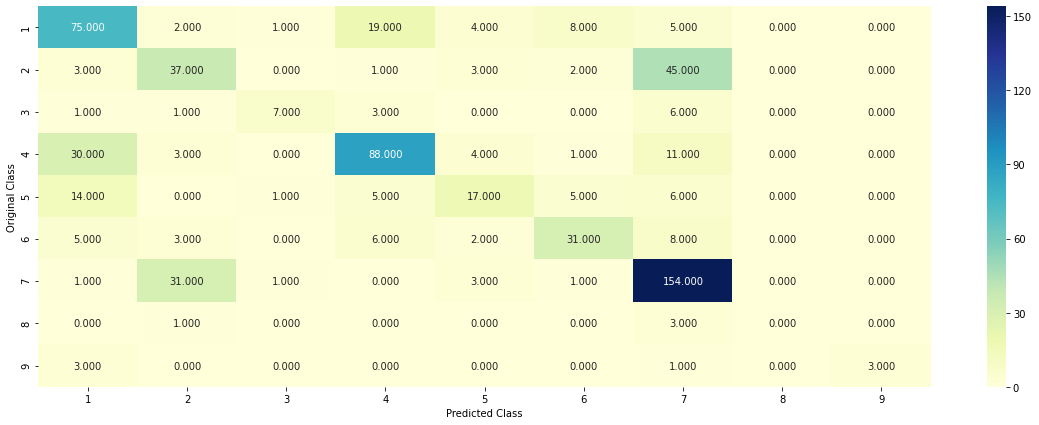

---------------------------------------- Precision Matrix (Columm Sum=1) ----------------------------------------


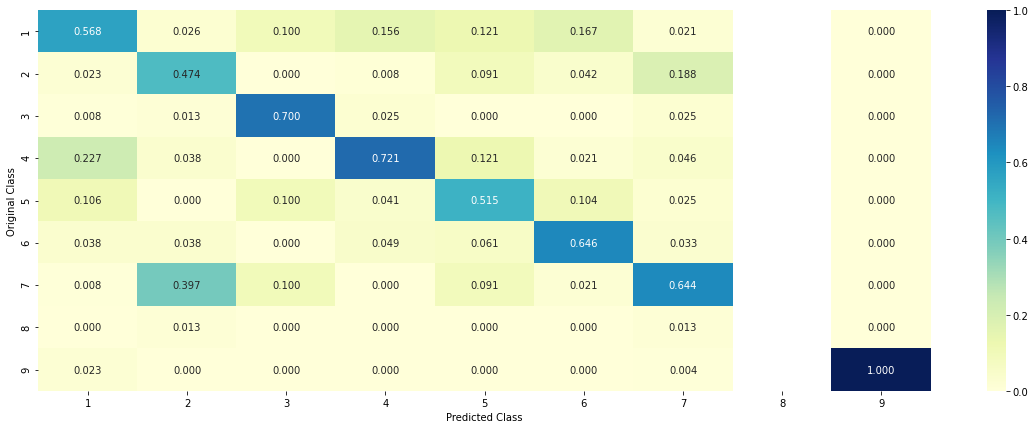

---------------------------------------- Recall Matrix (Row Sum=1) ----------------------------------------


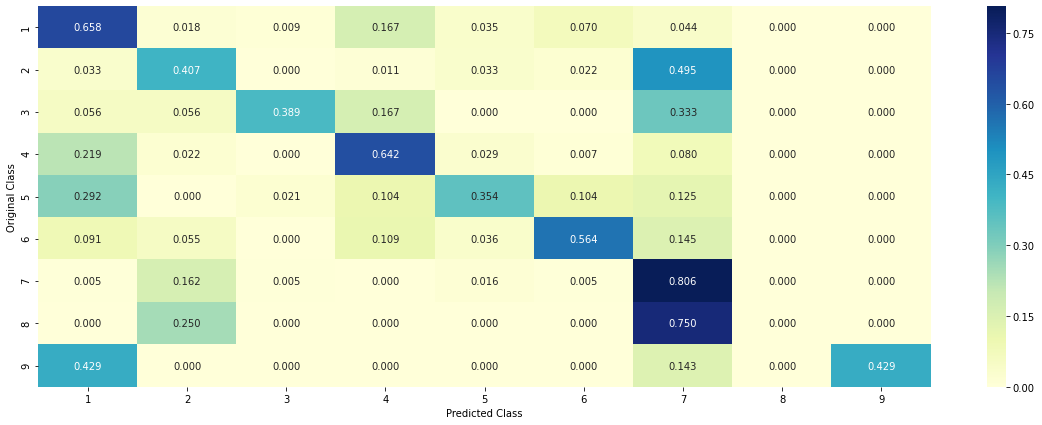

In [104]:
lr = LogisticRegression(C=0.1)

sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log Loss (Train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log Loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log Loss (Test) on the stacking classifier :",log_error)

print("Number of Mis-classified Point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

In [ ]:
#precision_matrix
#Of all the points which predicted to be class 4 (y_i_hat = 4), 72.1% of points are actually belongs to class 4.
#Of all the points which predicted to be class 2 (y_i_hat = 2), 39.7% of points are actually belongs to class 7.

#recall_matrix
#Of all the points which are originally belongs to class 7 (y_i = 7), 80.6% of points were classified to class 7.
#Of all the points which are originally belongs to class 8 (y_i = 8), 25% of points were classified to class 2.

**<font color=blue>Maximum Voting Classifier</font>**

Log Loss (Train) on the Voting Classifier : 0.832697476006161
Log Loss (CV) on the Voting Classifier : 1.2356898815837534
Log Loss (Test) on the Voting Classifier : 1.1726535396709512
Number of Mis-classified Point : 0.3669172932330827
---------------------------------------- Confusion Matrix ----------------------------------------


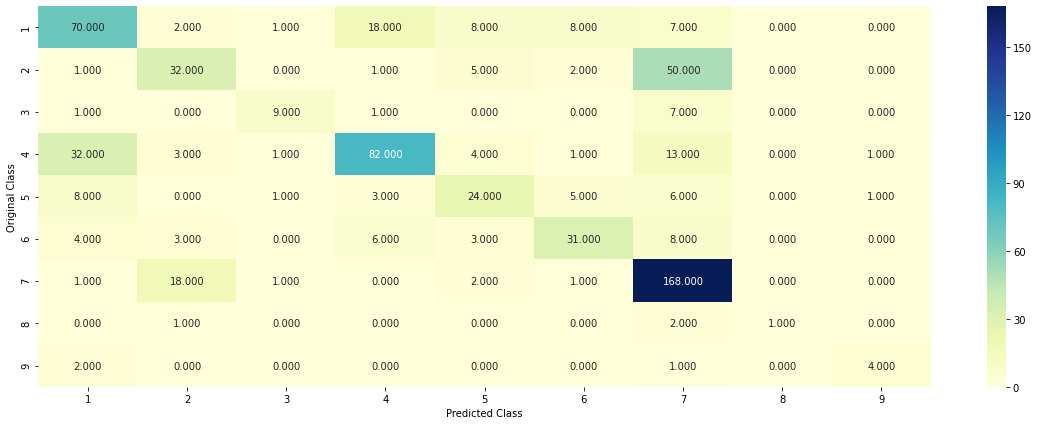

---------------------------------------- Precision Matrix (Columm Sum=1) ----------------------------------------


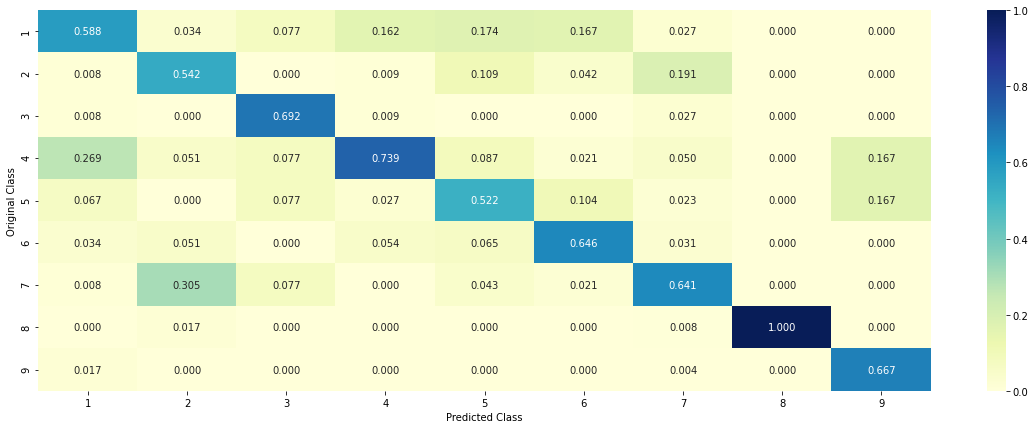

---------------------------------------- Recall Matrix (Row Sum=1) ----------------------------------------


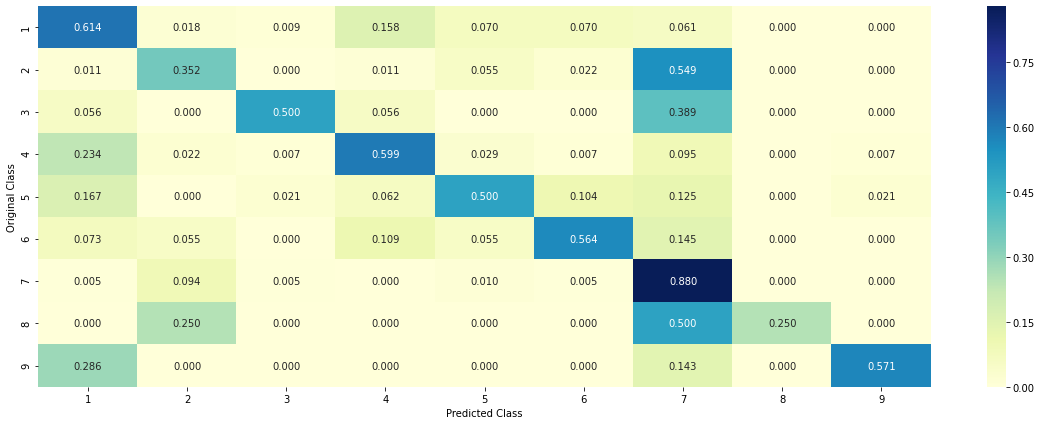

In [105]:
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)

print("Log Loss (Train) on the Voting Classifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log Loss (CV) on the Voting Classifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log Loss (Test) on the Voting Classifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of Mis-classified Point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])

plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))

In [ ]:
#precision_matrix
#Of all the points which predicted to be class 6 (y_i_hat = 6), 64.6% of points are actually belongs to class 6.
#Of all the points which predicted to be class 2 (y_i_hat = 2), 30.5% of points are actually belongs to class 7.

#recall_matrix
#Of all the points which are originally belongs to class 7 (y_i = 7), 88% of points were classified to class 7.
#Of all the points which are originally belongs to class 9 (y_i = 9), 28.6% of points were classified to class 1.